In [1]:
import argparse
import os
import math
import random

import torch as th
import torch.distributed as dist
import torchvision as tv
import blobfile as bf
from PIL import Image
import warnings
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

from guided_diffusion.image_datasets import load_data

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

warnings.filterwarnings('ignore')
class Arguments(object):
    def __init__(self, dictionary):
        """Constructor"""
        for key in dictionary:
            setattr(self, key, dictionary[key])
            
def read_pil(path, d1=False):
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
        if d1:
            pil_image = pil_image.convert("L")
        else:
            pil_image = pil_image.convert("RGB")
    return pil_image

/home/as3ek/.conda/envs/hist/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_imgs(idx, results_path, name=None):
    images_path = os.path.join(results_path, "images")
    classes_path = os.path.join(results_path, "labels")
    samples_path = os.path.join(results_path, "samples")
    
    if name is None:
        img_path = os.listdir(images_path)[idx]
    else:
        img_path = name

    img_pil = read_pil(os.path.join(images_path, img_path))
    clz_pil = read_pil(os.path.join(classes_path, img_path), d1=True)
    smp_pil = read_pil(os.path.join(samples_path, img_path))
    clz_arr = np.array(clz_pil)
    clz_pil_scaled = Image.fromarray(clz_arr/clz_arr.max() * 255.).convert("L")
        
    return img_path, [clz_pil_scaled, clz_pil], [color_class_map(clz_pil), img_pil, smp_pil]

def get_num_images(results_path):
    images_path = os.path.join(results_path, "images")
    classes_path = os.path.join(results_path, "labels")
    samples_path = os.path.join(results_path, "samples")
    
    assert len(os.listdir(images_path)) == len(os.listdir(classes_path))
    assert len(os.listdir(images_path)) == len(os.listdir(samples_path))
    
    return len(os.listdir(images_path))

def display_imgs(imgs, masks=None, titles=[], turing=False, is_sample=False, is_real=False, save=False, filename=None):
    if turing:
        if is_sample:
            rand = 2
        elif is_real:
            rand = 1
        else:
            rand = random.randint(1,2)
        
        imgs = [imgs[0]] + [imgs[rand], imgs[rand]]
        
        
    # Create a figure with four subplots
    fig, axs = plt.subplots(1, len(imgs), figsize=(24, 12))

    # Set different titles for each subplot
    for i, ax in enumerate(axs):
        if len(titles) == len(imgs):
            ax.set_title(str(titles[i]))
        
        
        ax.imshow(imgs[i])
        ax.axis("off")
        
        if masks is not None:
            if masks[i] is not None:
                ax.imshow(masks[i], alpha=0.3)
    
    # Reduce the gap between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    # Show the figure
    if save:
        if filename is not None:
            plt.savefig(filename, dpi=300)
    plt.show()
    
    
def color_class_map(class_map, class_id=0):
    cmap = np.array([[0,0,0],
                     [0, 0, 255], # Blue
                     [255, 0, 0], # Red
                     [255, 128, 0], # Orange
                     [255, 255, 0], # Yellow
                     [0, 255, 0], # Green 
                     [128, 0, 255]]) # Purple
    
    image = np.uint8(np.array(class_map))
    
    if class_id != 0:
        image[image != class_id] = 0
    
    return Image.fromarray(cmap[image].astype(np.uint8))

crag_45__896_768.png
Fake


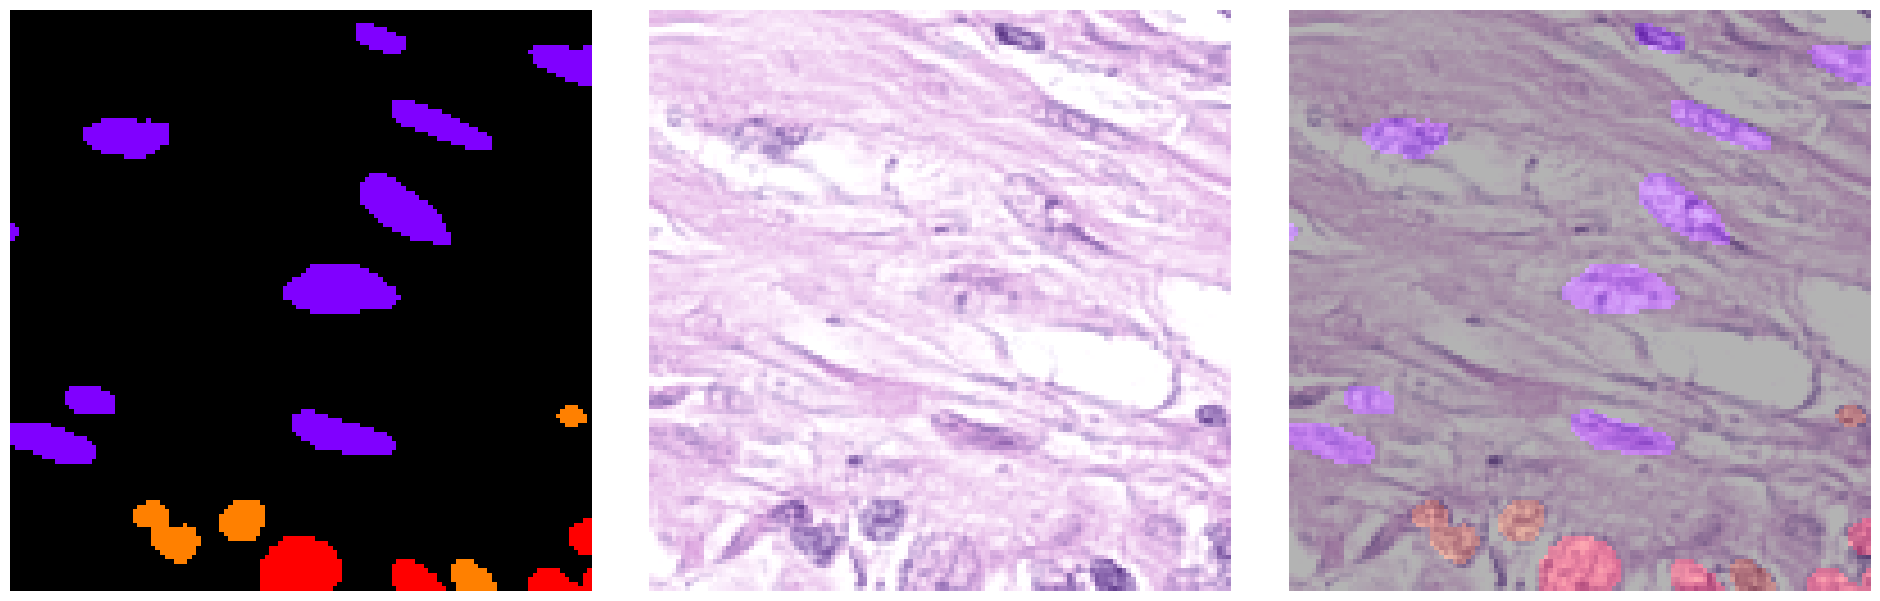

Real


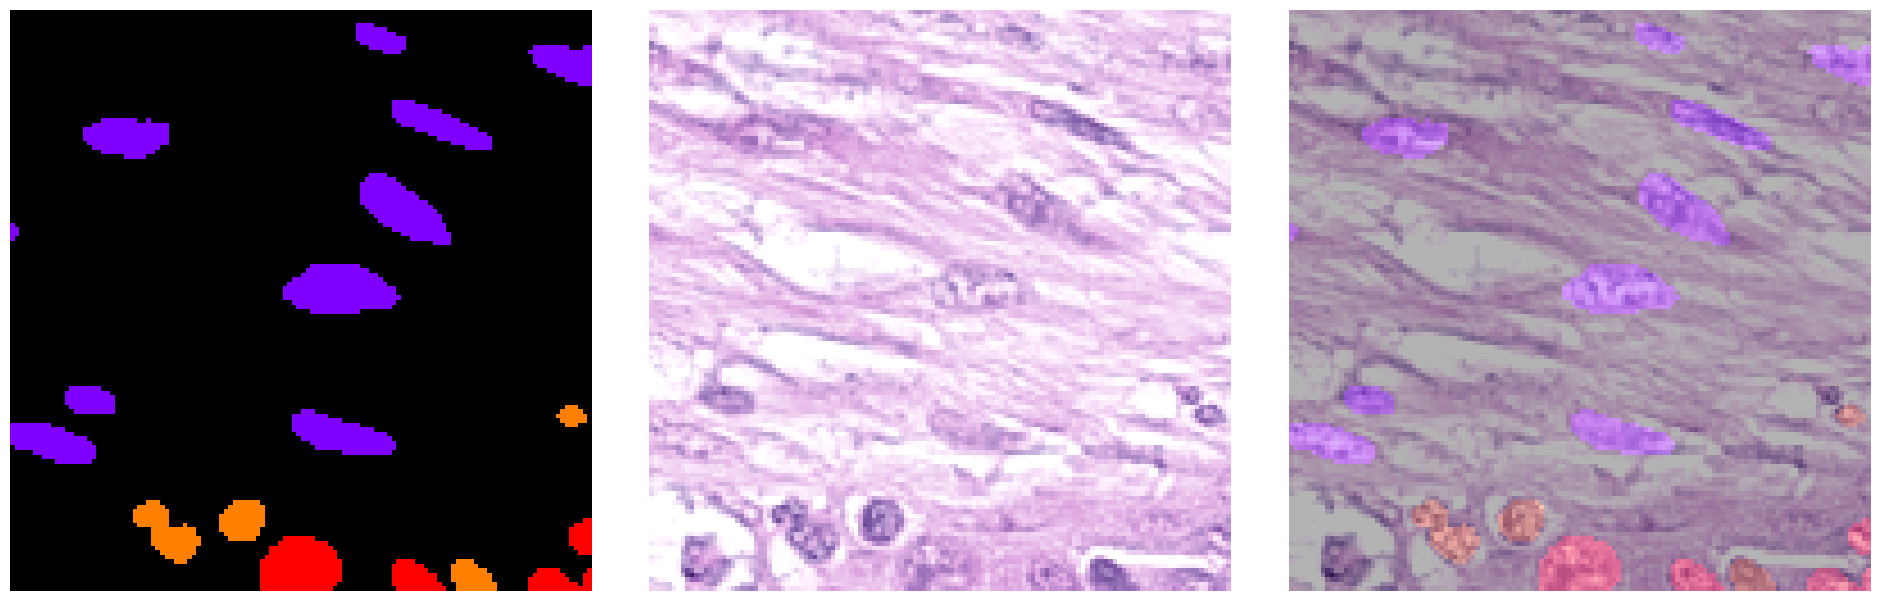

995 crag_45__896_768.png


In [3]:
## Visualize Random Samples
results_path = "/oldscratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"
num_samples = get_num_images(results_path)

idx = random.randint(1, num_samples) - 1
name, _, smp_zip = load_imgs(idx, results_path)

# Fake
print(name)
print("Fake")
display_imgs(smp_zip, masks=[None, None, smp_zip[0]], turing=True, is_sample=True, is_real=False)
# Real
print("Real")
display_imgs(smp_zip, masks=[None, None, smp_zip[0]], turing=True, is_sample=False, is_real=True)
print(idx, name)

smp_zip[0].save('assets/samples/' + str(idx)+'mask.png')
smp_zip[1].save('assets/samples/' + str(idx)+'real.png')
smp_zip[2].save('assets/samples/' + str(idx)+'syn.png')

In [3]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)


def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

In [44]:
# Use float64 for accuracy.
betas = get_named_beta_schedule("cosine", 100)
betas = np.array(betas, dtype=np.float64)
assert len(betas.shape) == 1, "betas must be 1-D"
assert (betas > 0).all() and (betas <= 1).all()

num_timesteps = int(betas.shape[0])

alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)
assert alphas_cumprod_prev.shape == (num_timesteps,)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
log_one_minus_alphas_cumprod = np.log(1.0 - alphas_cumprod)
sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)

In [45]:
def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    """
    Diffuse the data for a given number of diffusion steps.

    In other words, sample from q(x_t | x_0).

    :param x_start: the initial data batch.
    :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
    :param noise: if specified, the split-out normal noise.
    :return: A noisy version of x_start.
    """
    if noise is None:
        noise = th.randn_like(x_start)
    assert noise.shape == x_start.shape
    return (
        _extract_into_tensor(sqrt_alphas_cumprod, t, x_start.shape) * x_start
        + _extract_into_tensor(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        * noise
    )

In [46]:
## Visualize Random Samples
results_path = "/oldscratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"
num_samples = get_num_images(results_path)

idx = random.randint(1, num_samples) - 1
name, _, smp_zip = load_imgs(idx, results_path)

In [47]:
from torchvision import transforms
import torch

# Load your PIL image
pil_image = smp_zip[1]

# Define a transformation to convert PIL image to a Torch tensor
transform = transforms.ToTensor()

# Apply the transformation to the image
tensor_image = transform(pil_image)

In [68]:
tensor_image1 = q_sample(tensor_image.unsqueeze(0), 40, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


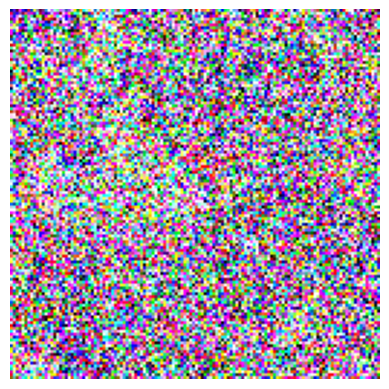

In [69]:
import matplotlib.pyplot as plt
import torch

# Assuming you have your tensor image as 'tensor_image'

# Convert the tensor to a NumPy array
numpy_image = tensor_image1[0].numpy()

# Display the image using Matplotlib
plt.imshow(numpy_image.transpose(1, 2, 0))  # PyTorch tensors are (C, H, W)
plt.axis('off')
plt.show()

Sample: 1


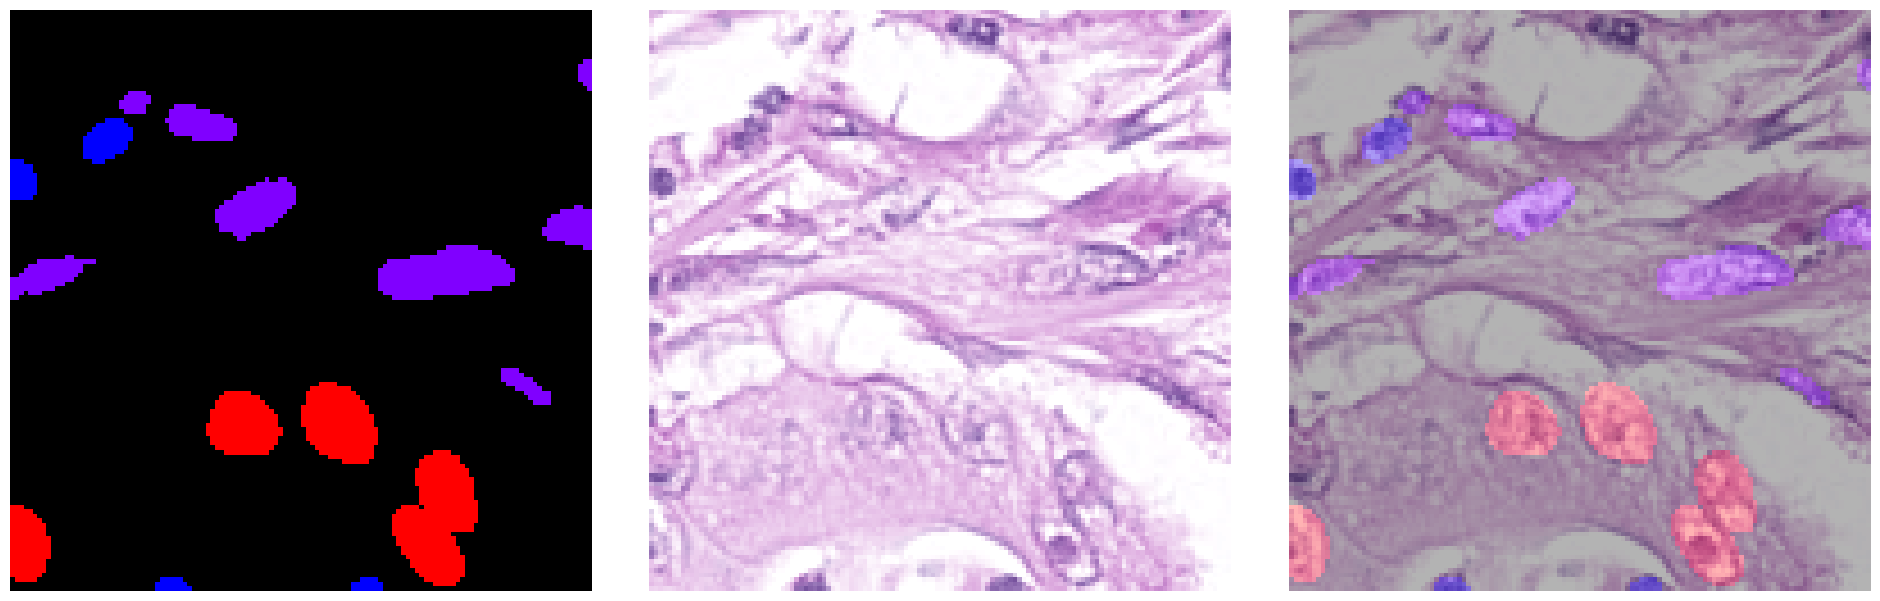

Sample: 2


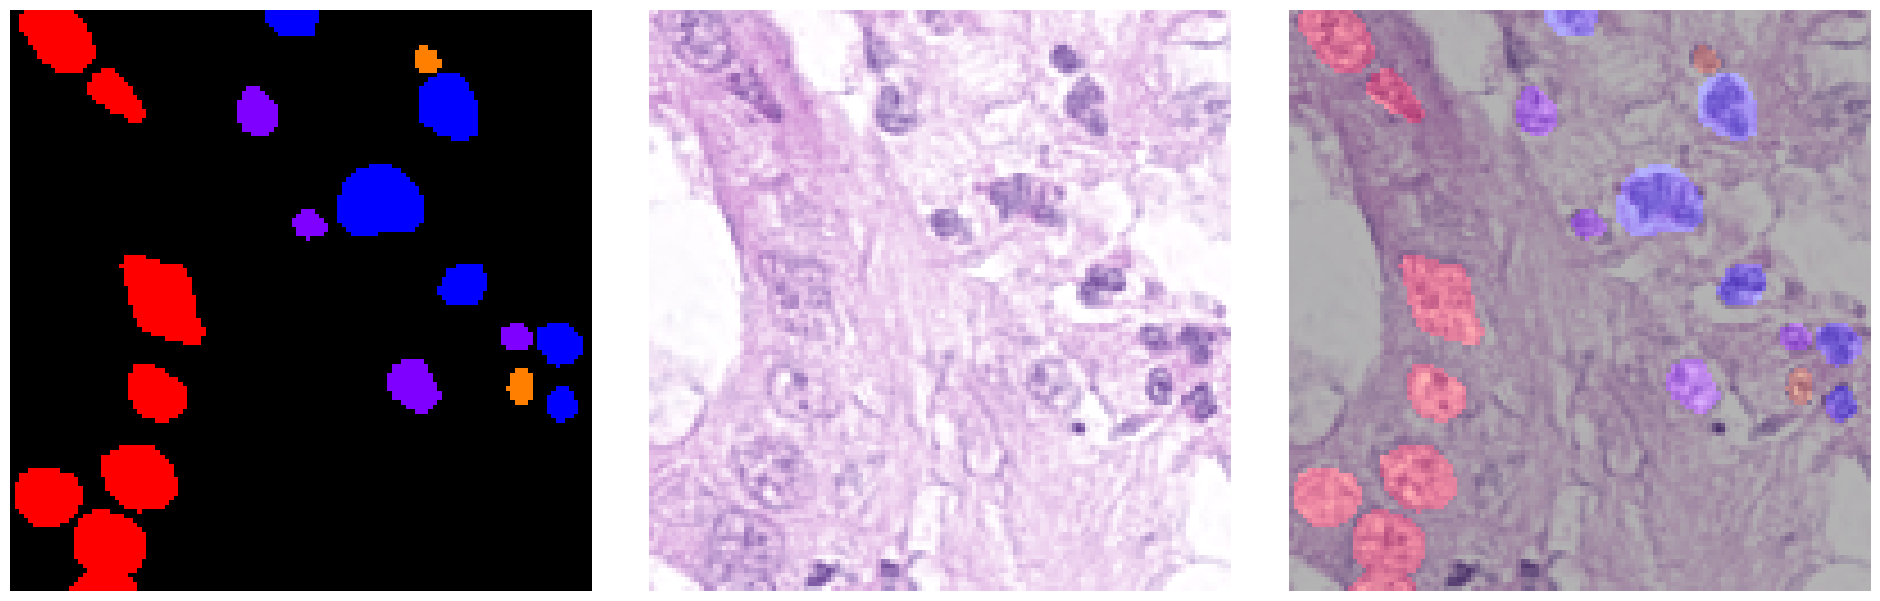

Sample: 3


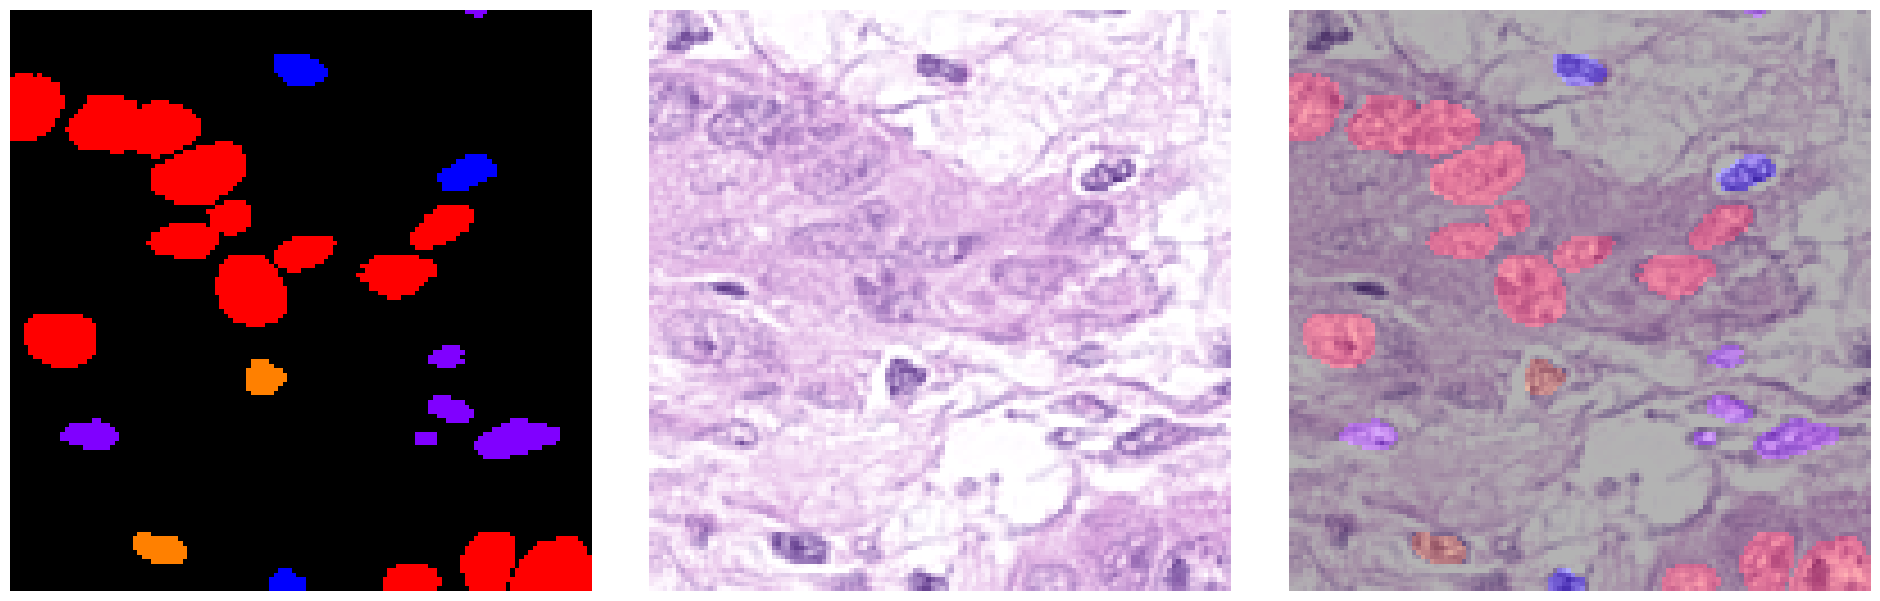

Sample: 4


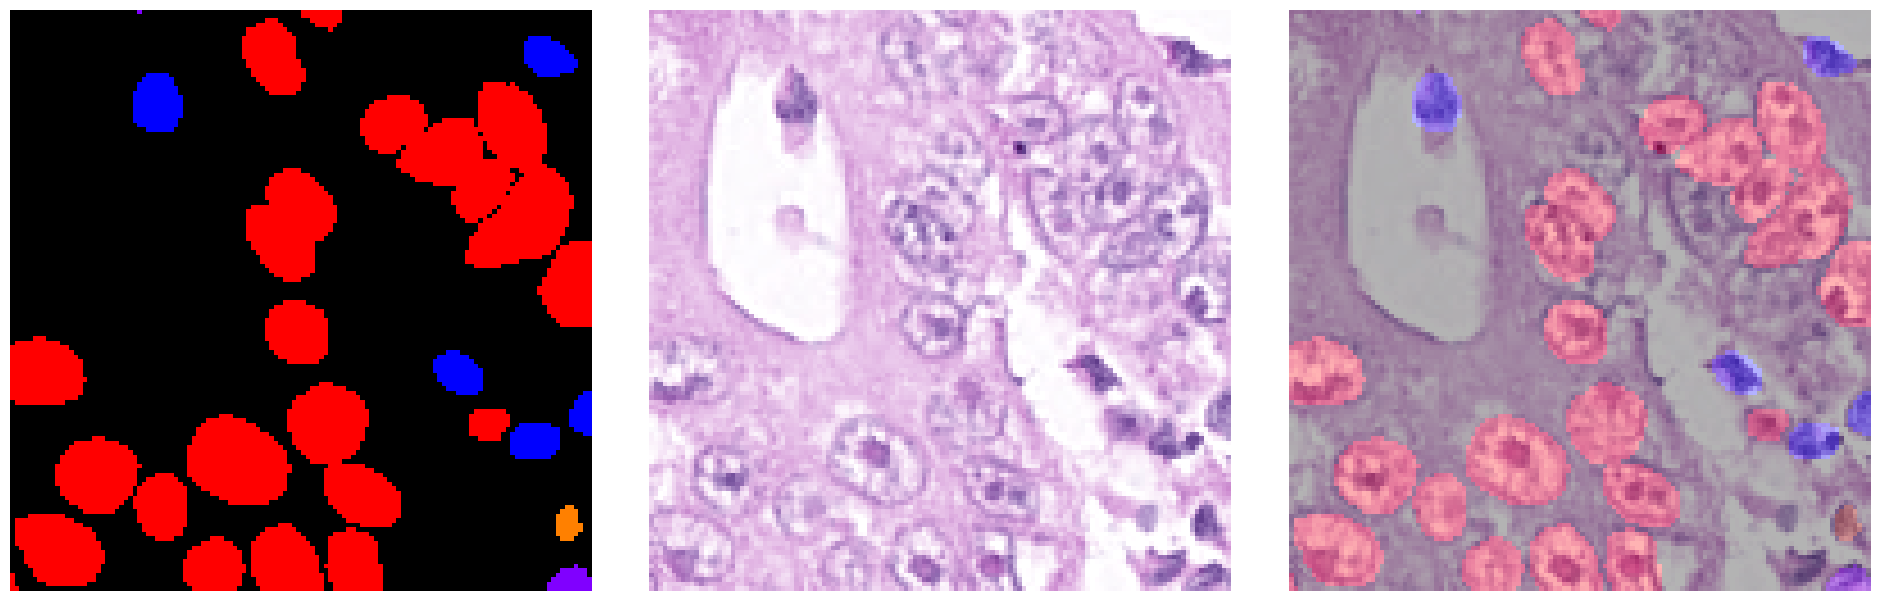

Sample: 5


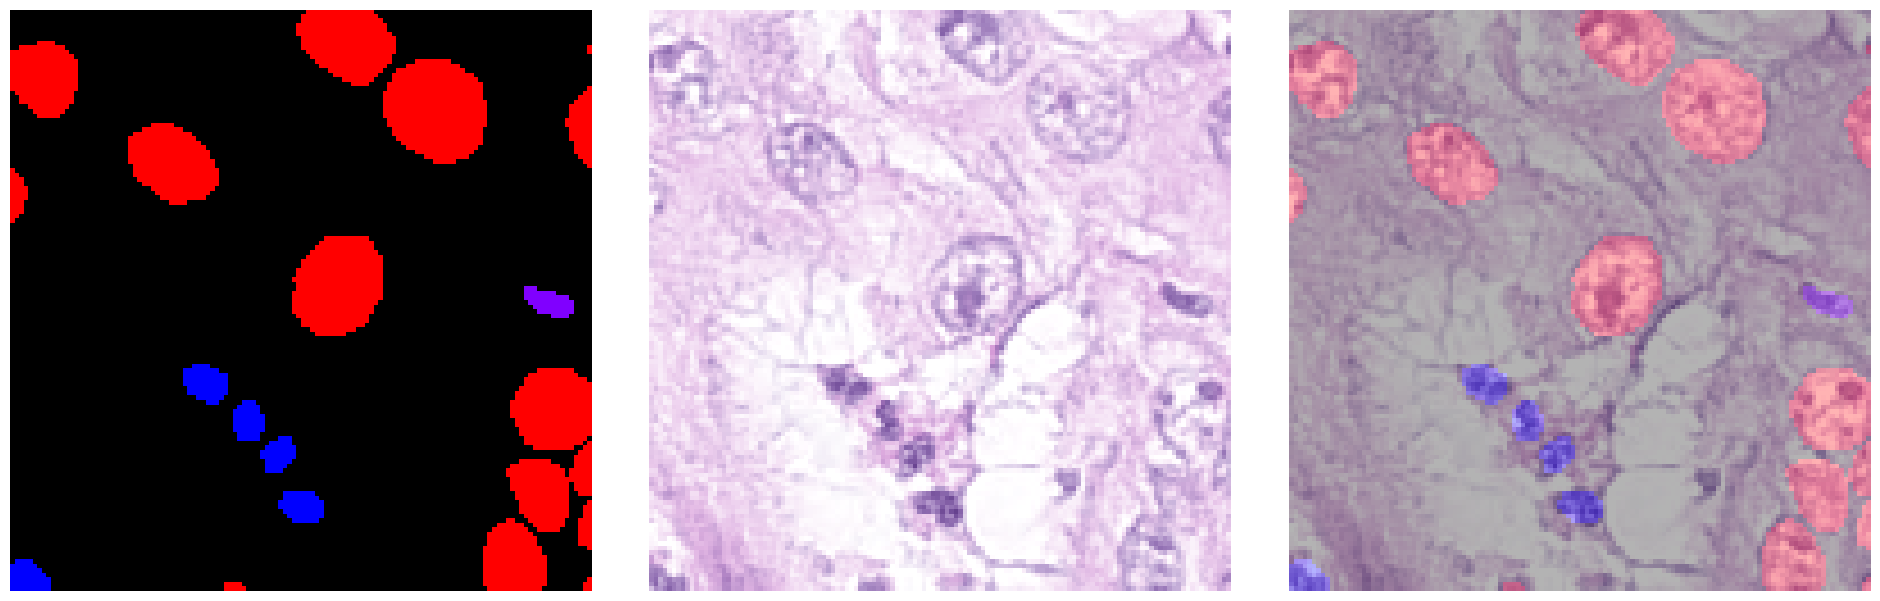

Sample: 6


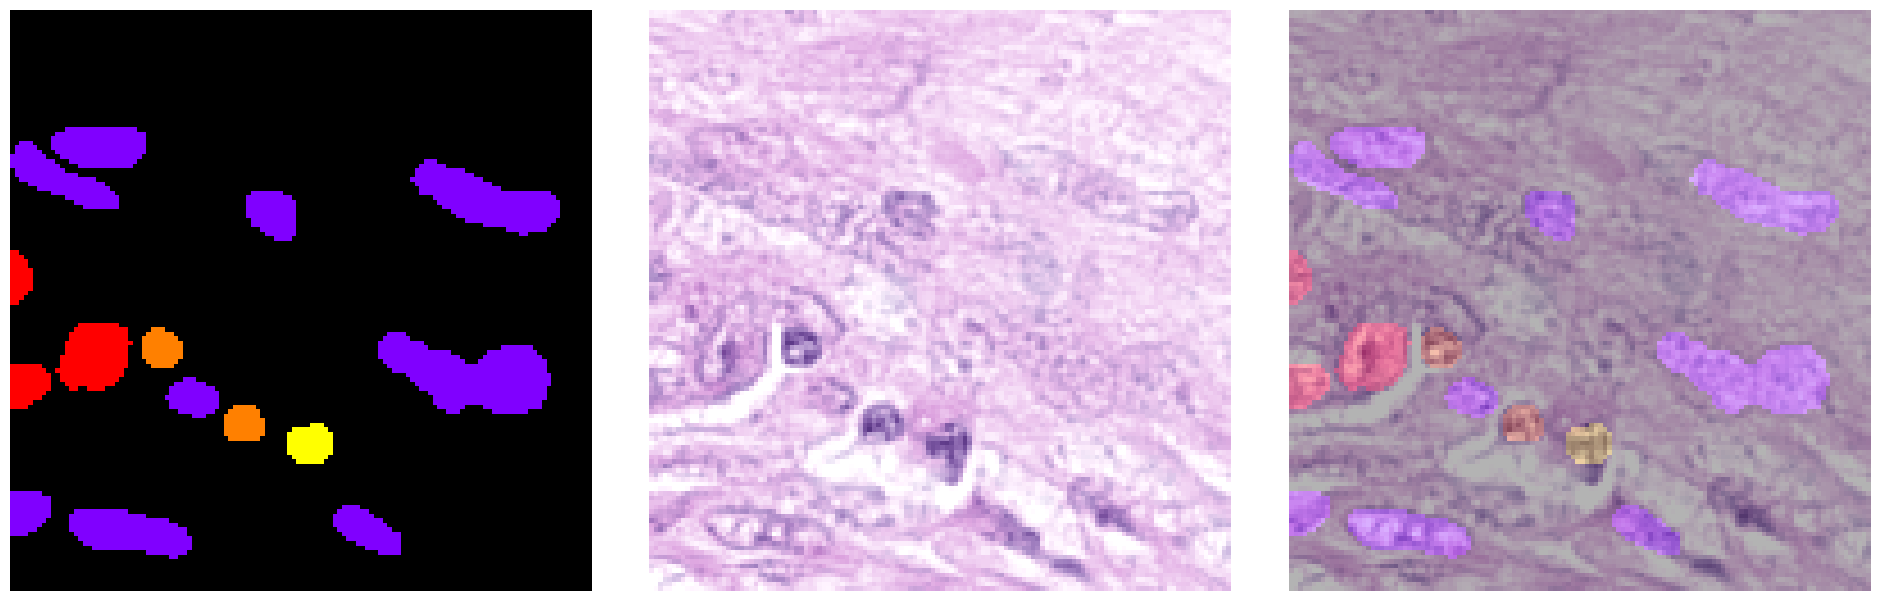

Sample: 7


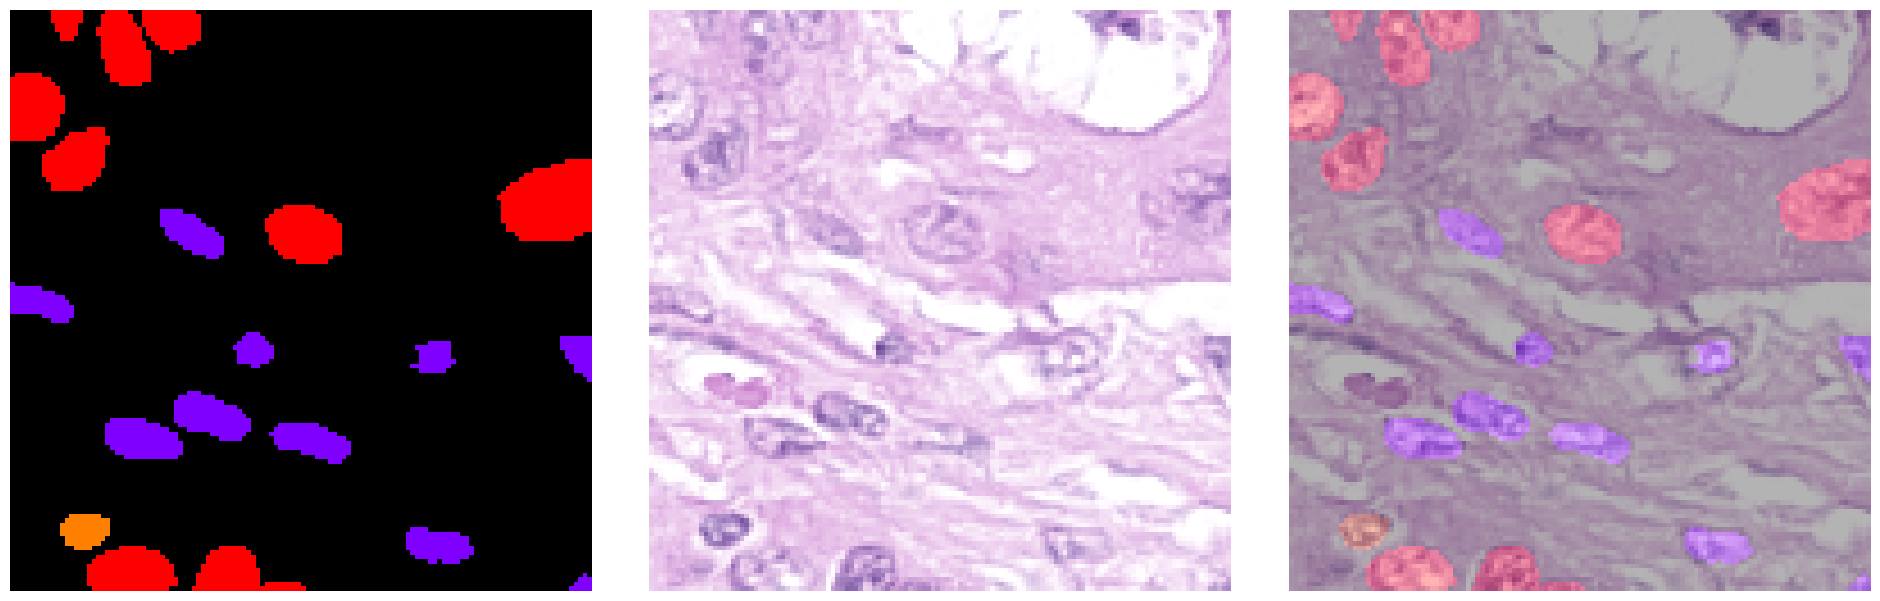

Sample: 8


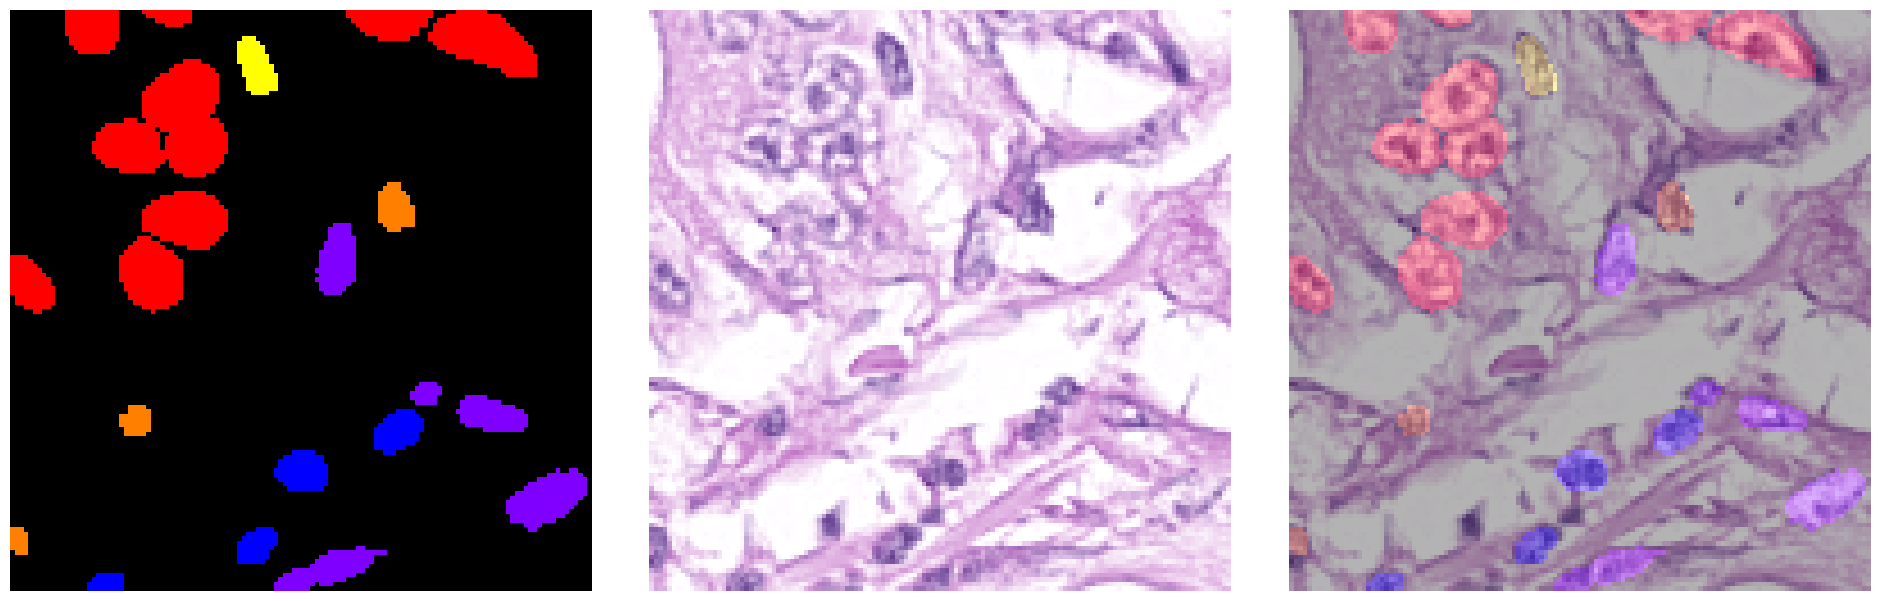

Sample: 9


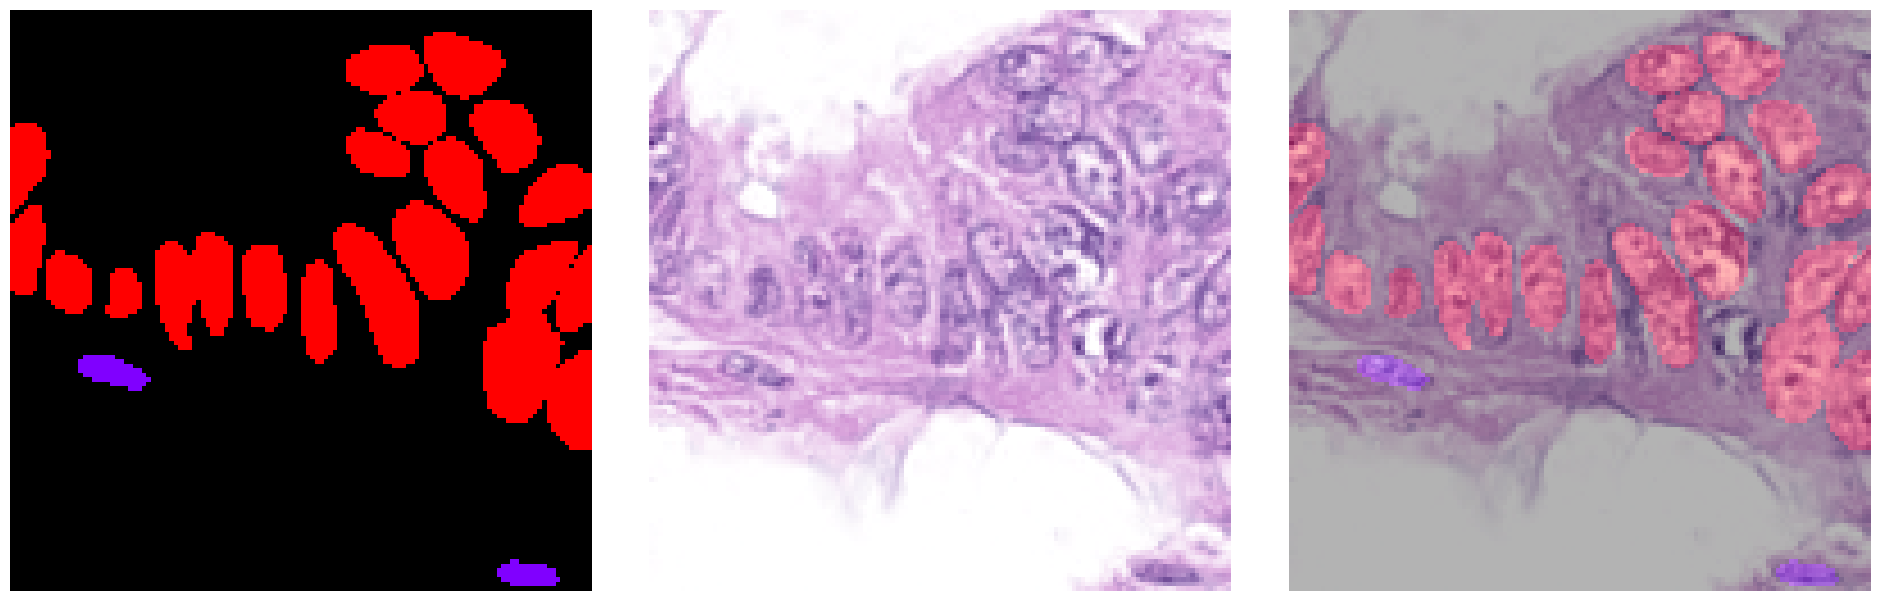

Sample: 10


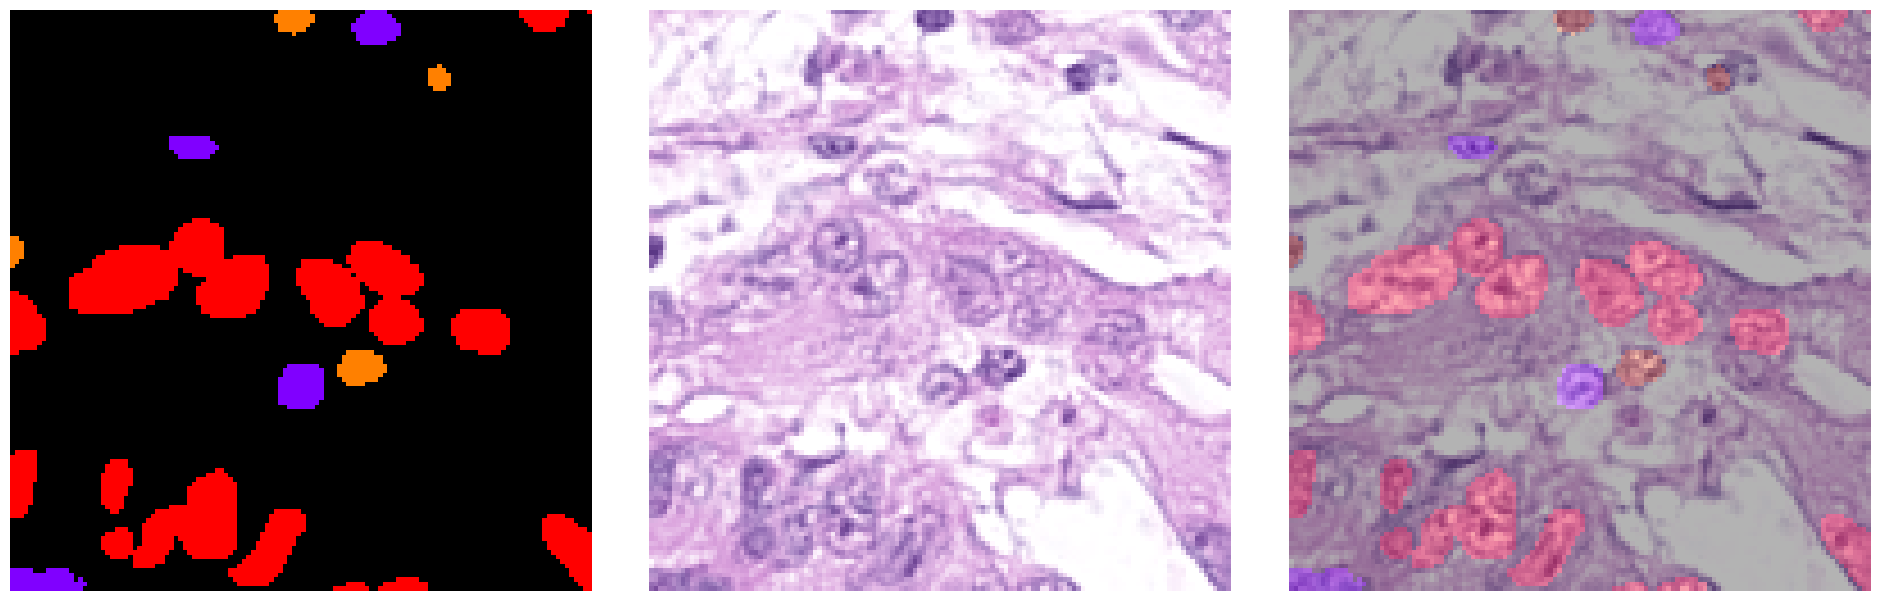

Sample: 11


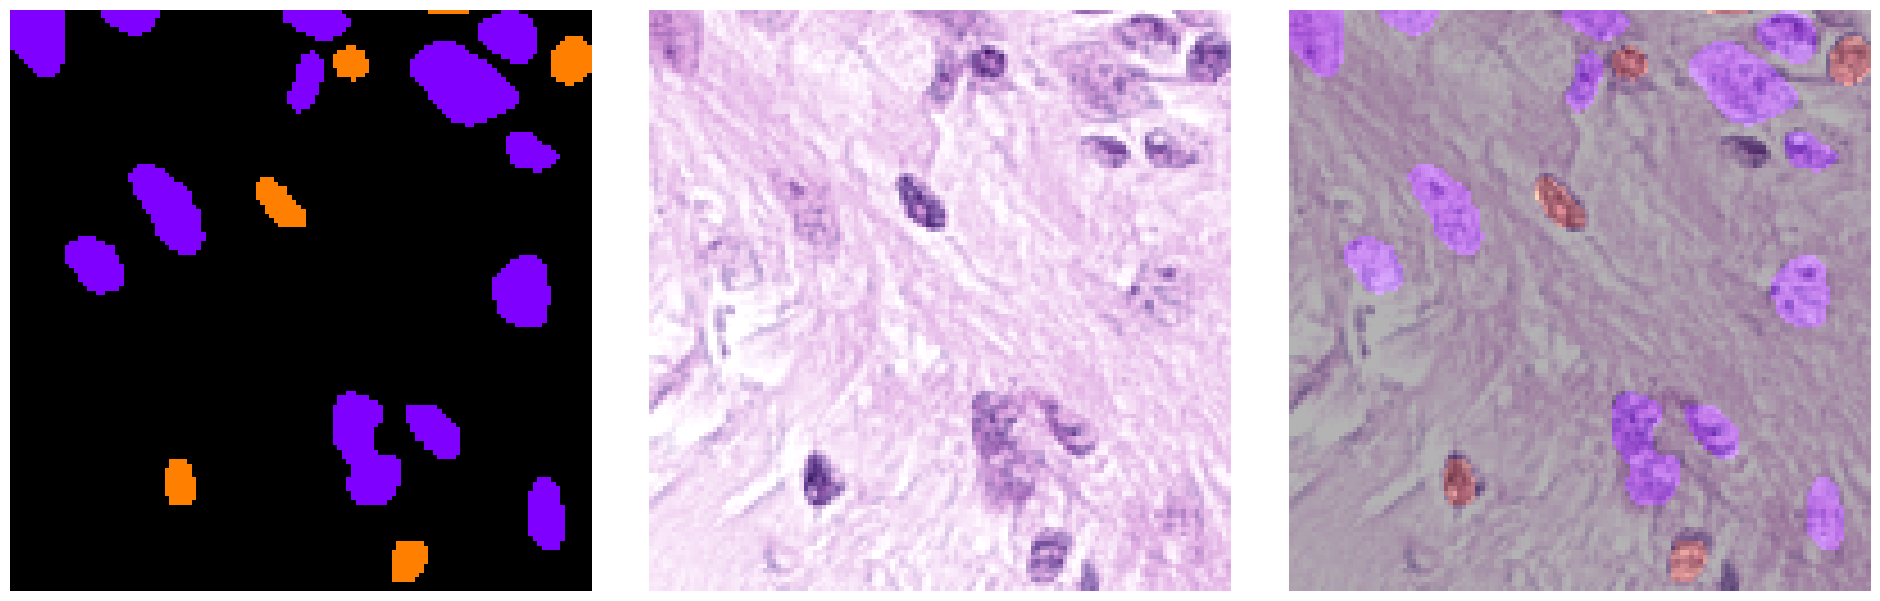

Sample: 12


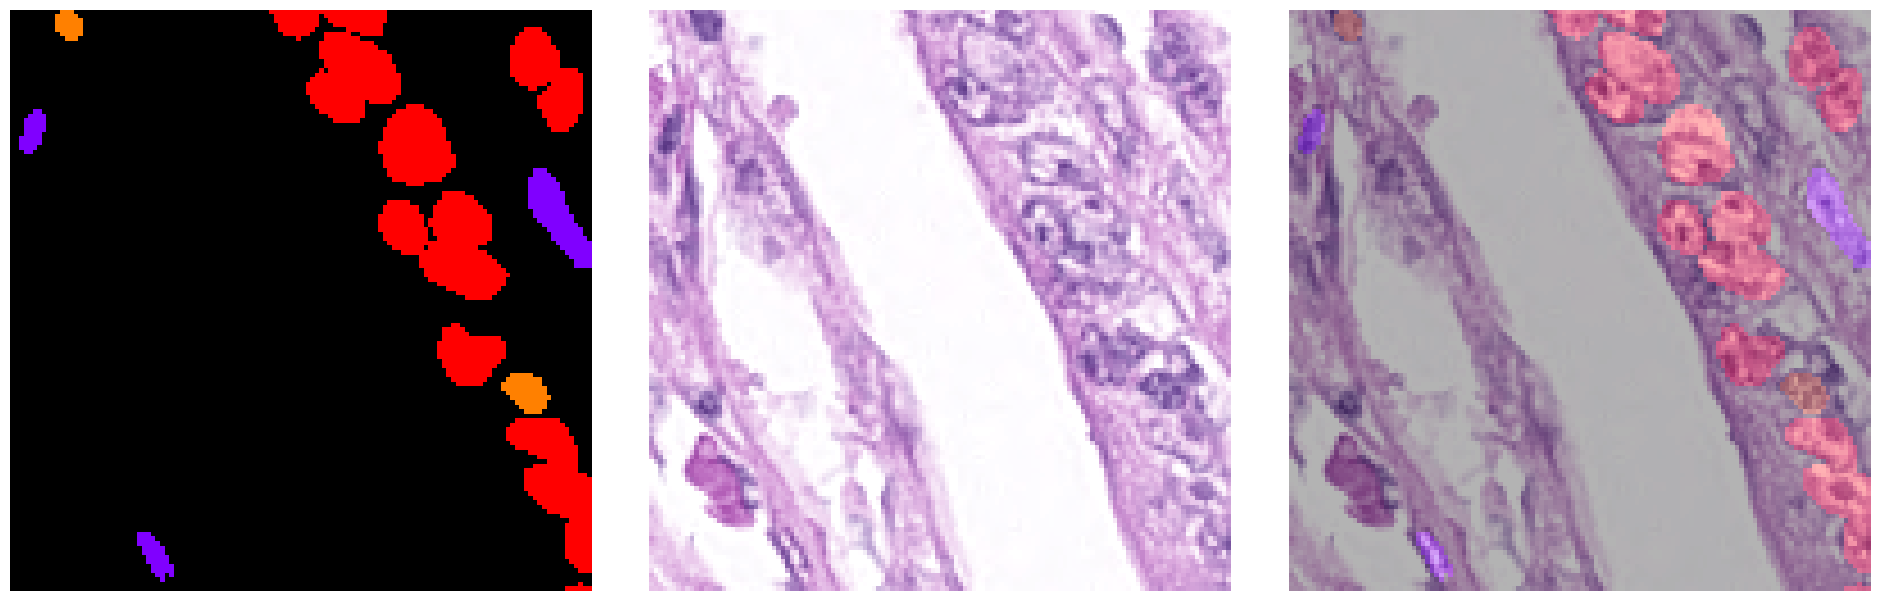

Sample: 13


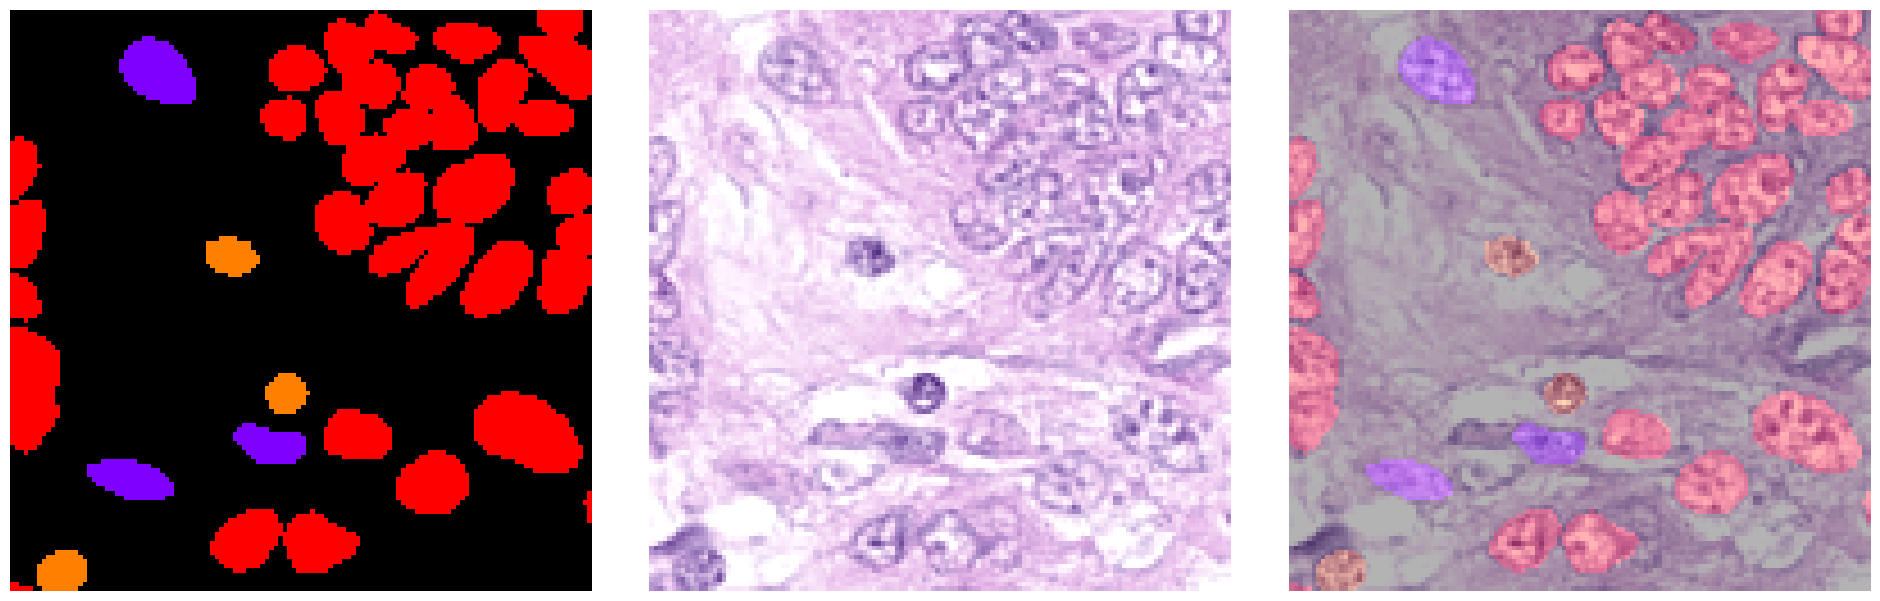

Sample: 14


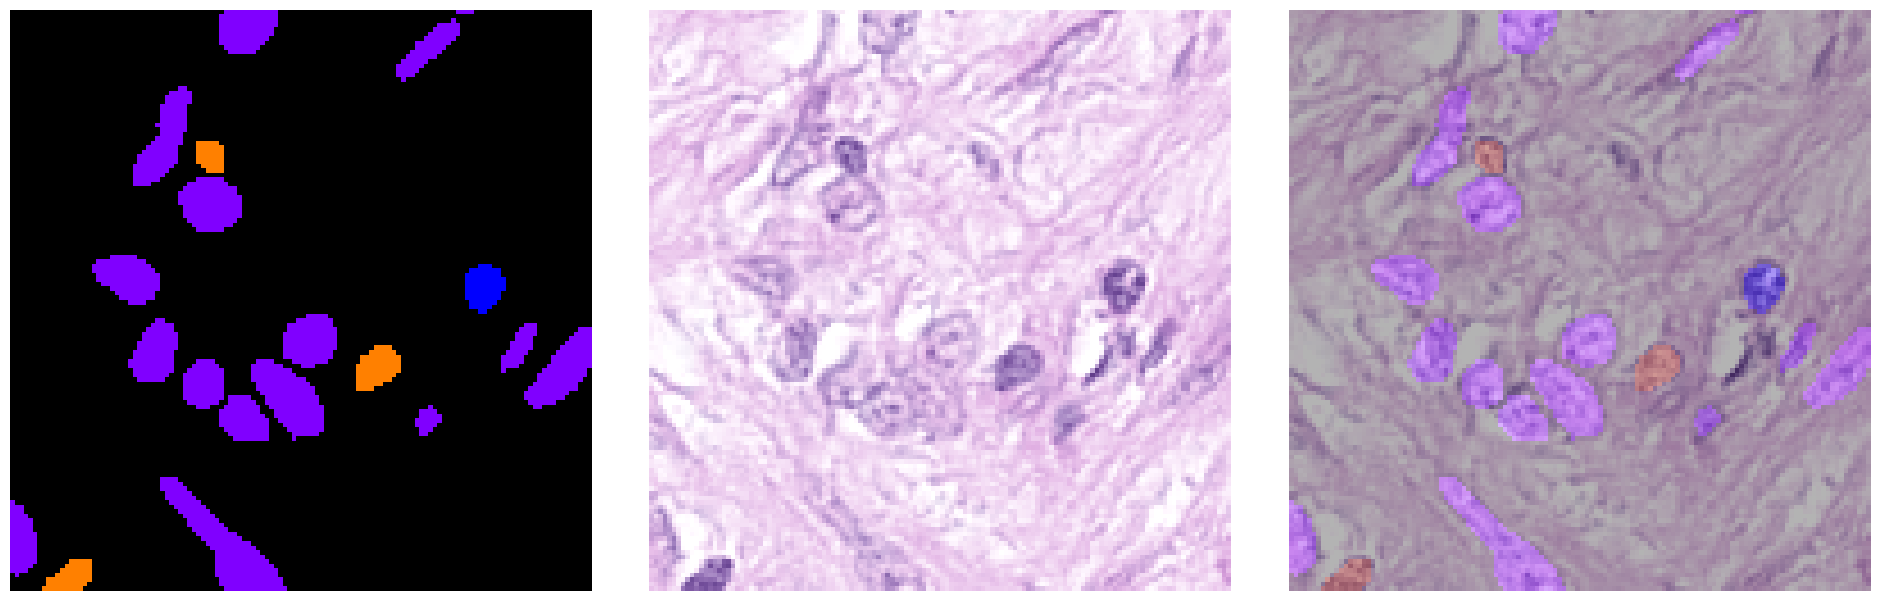

Sample: 15


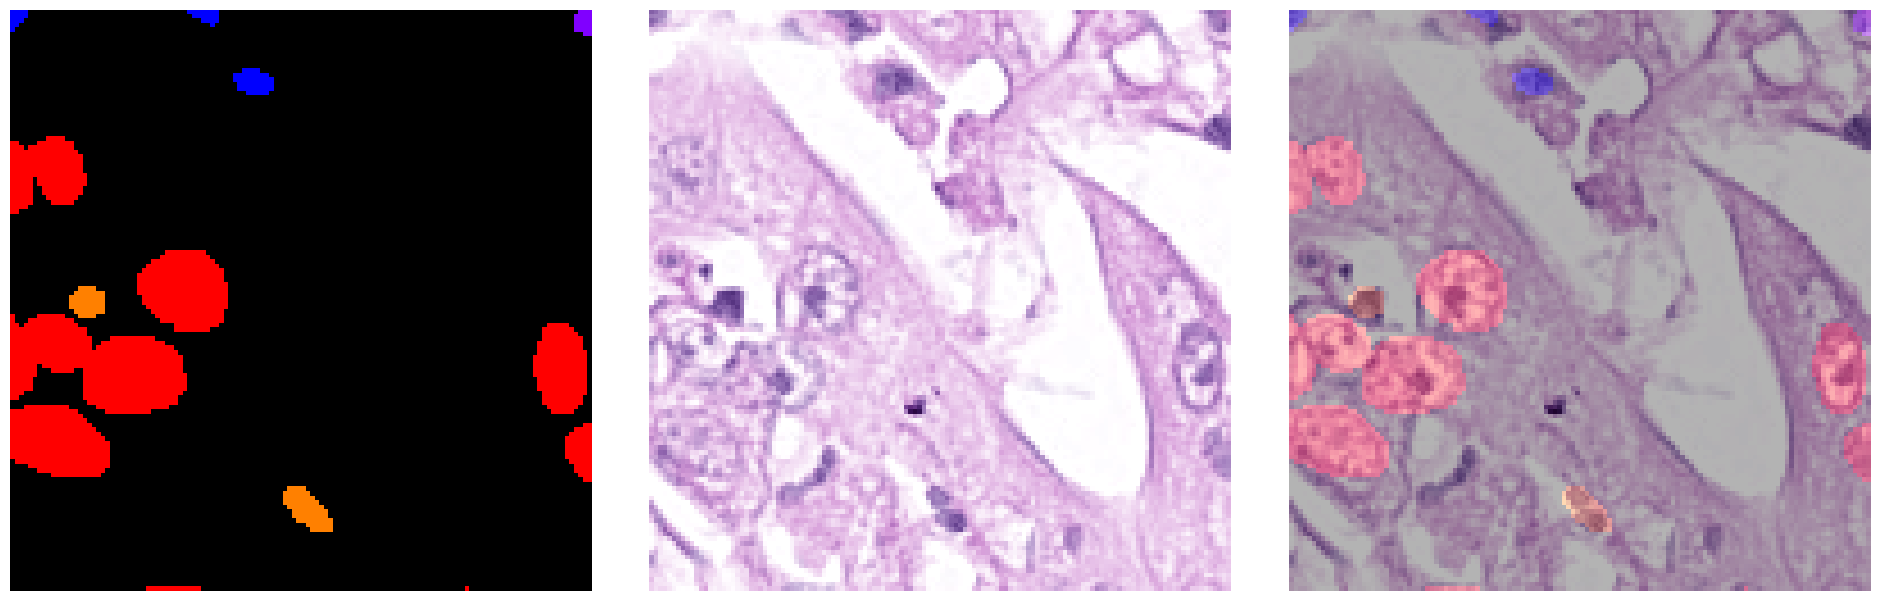

Sample: 16


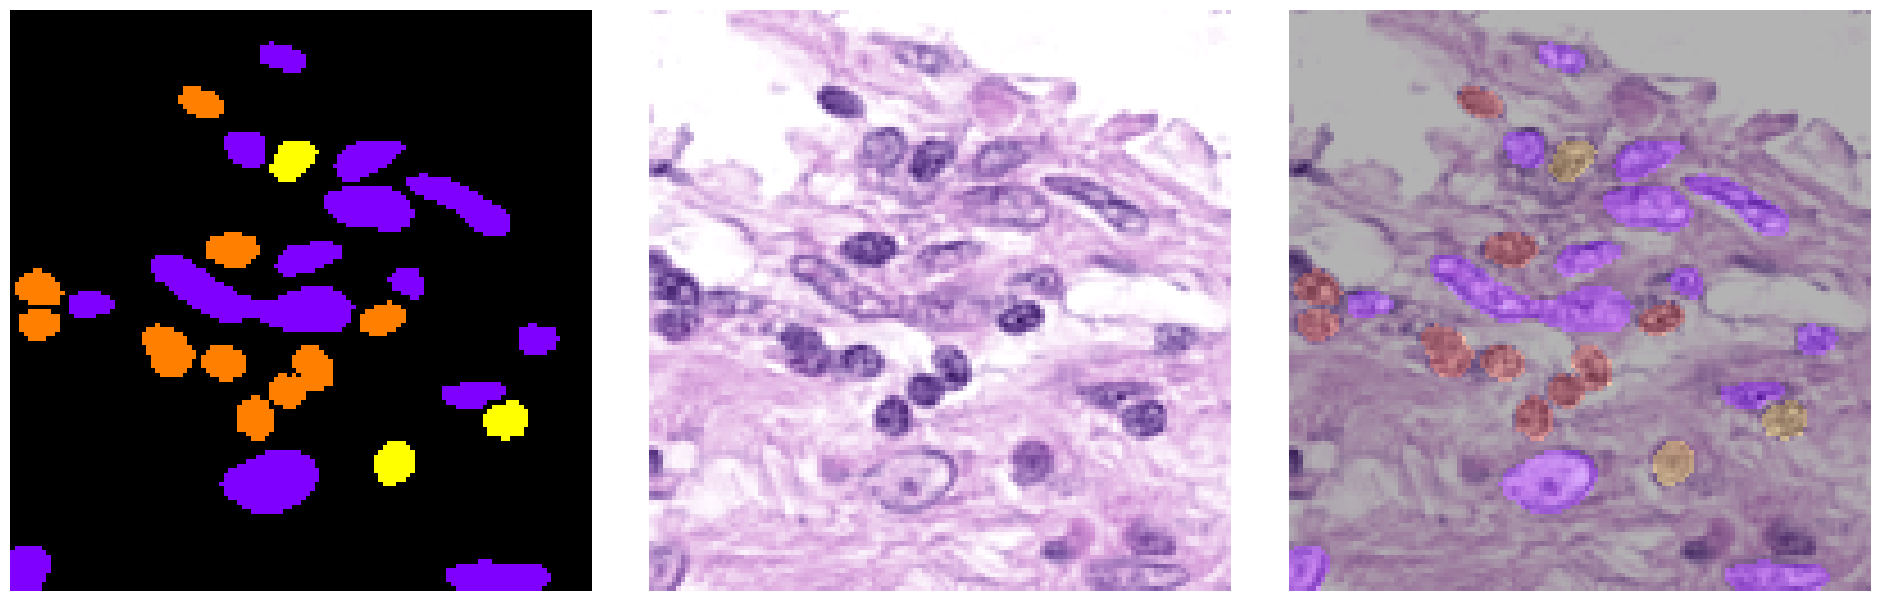

Sample: 17


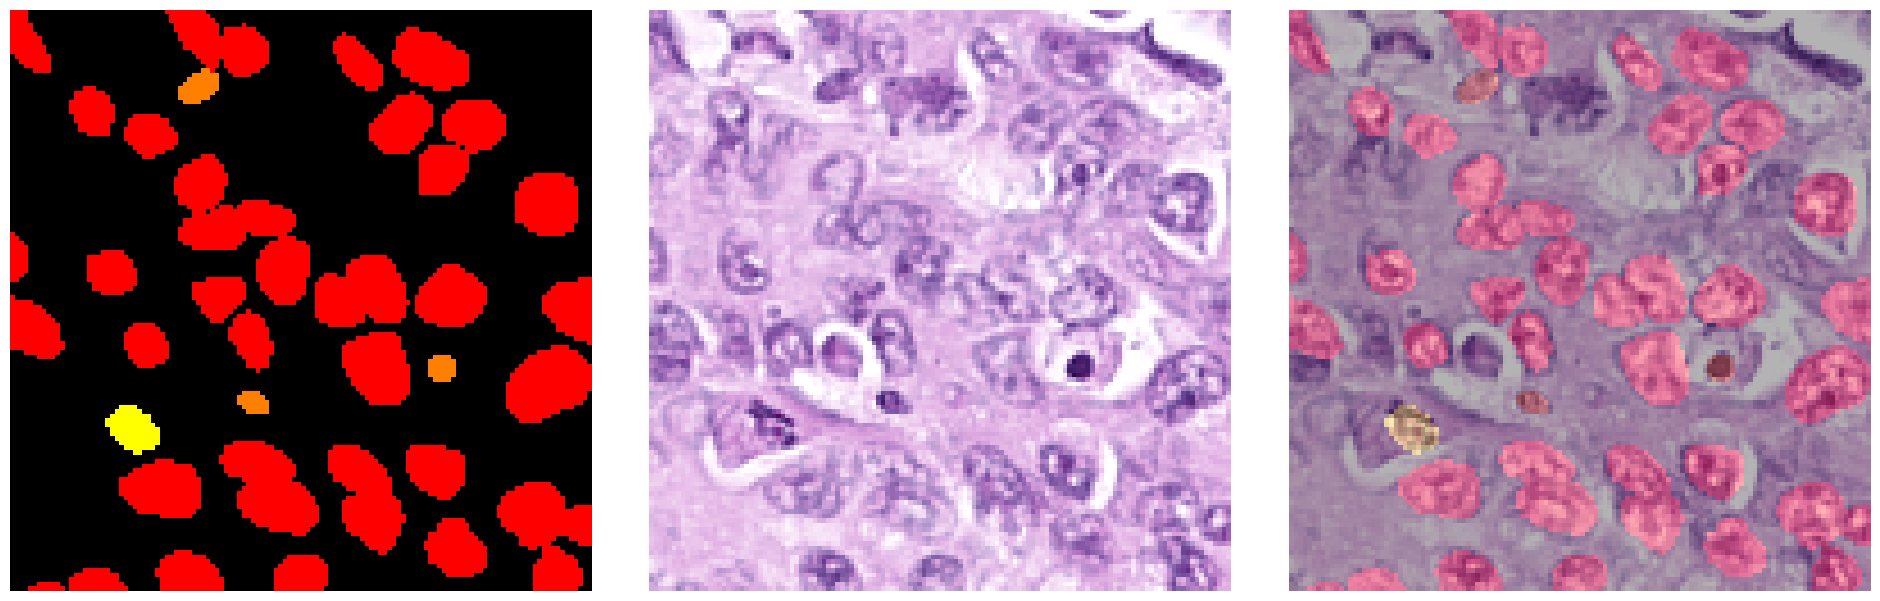

Sample: 18


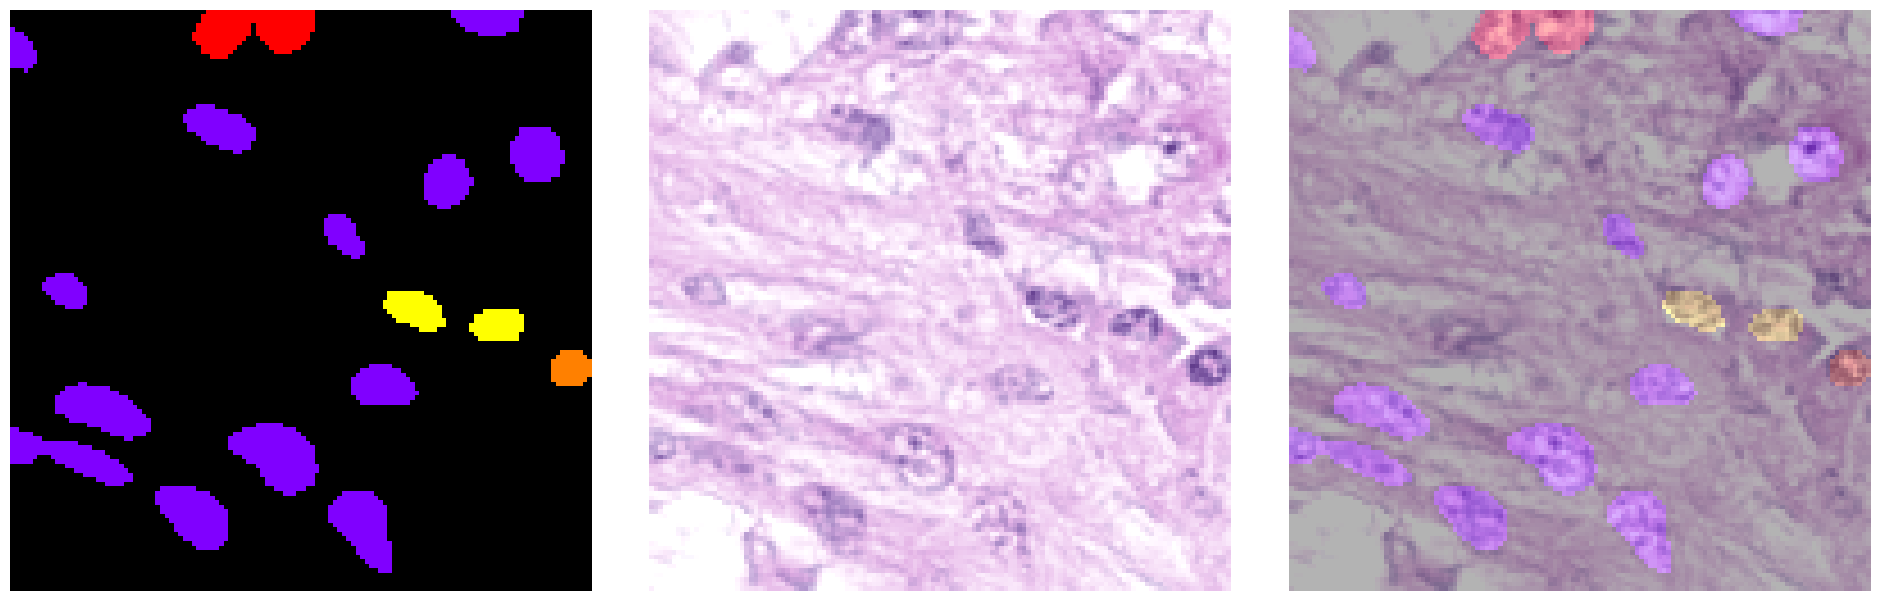

Sample: 19


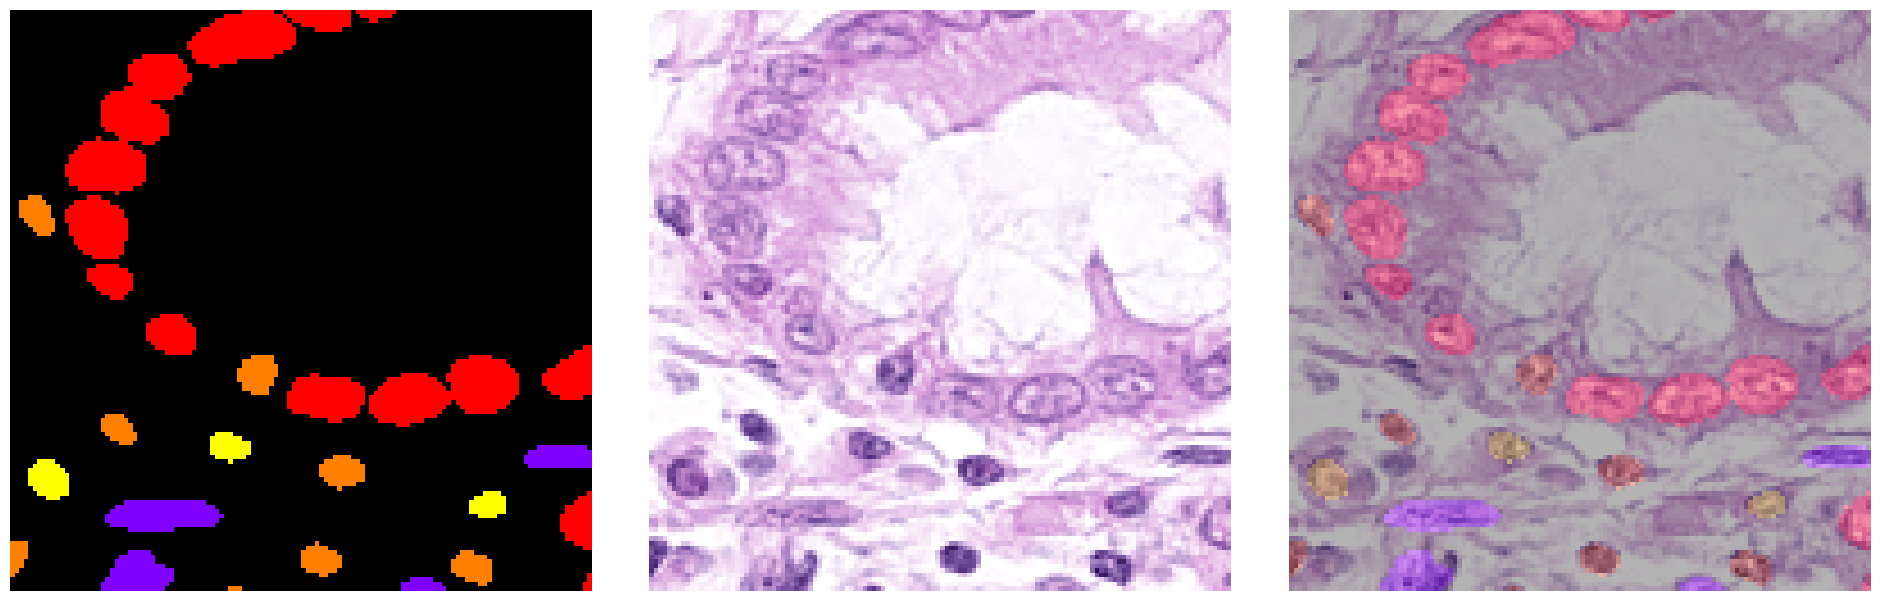

Sample: 20


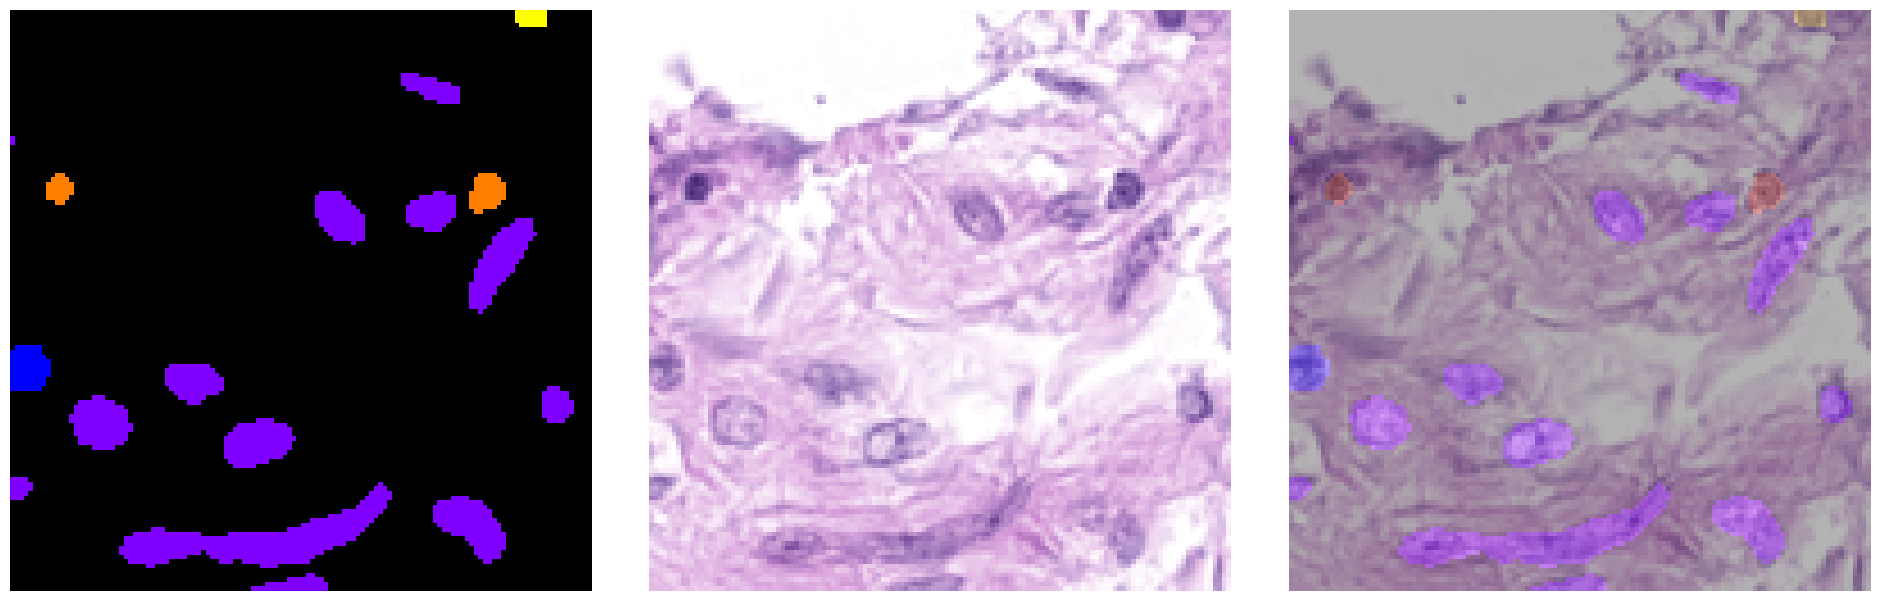

Sample: 21


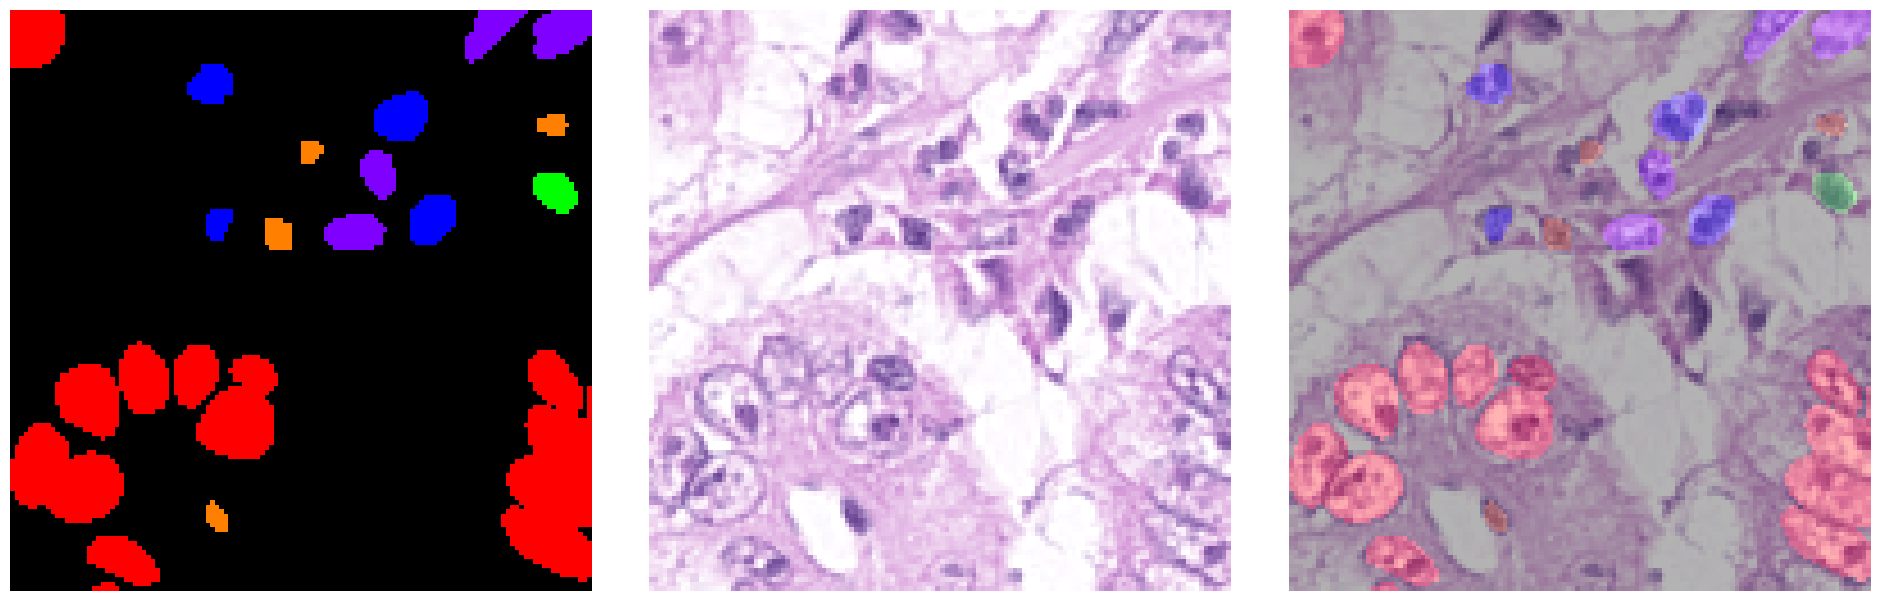

Sample: 22


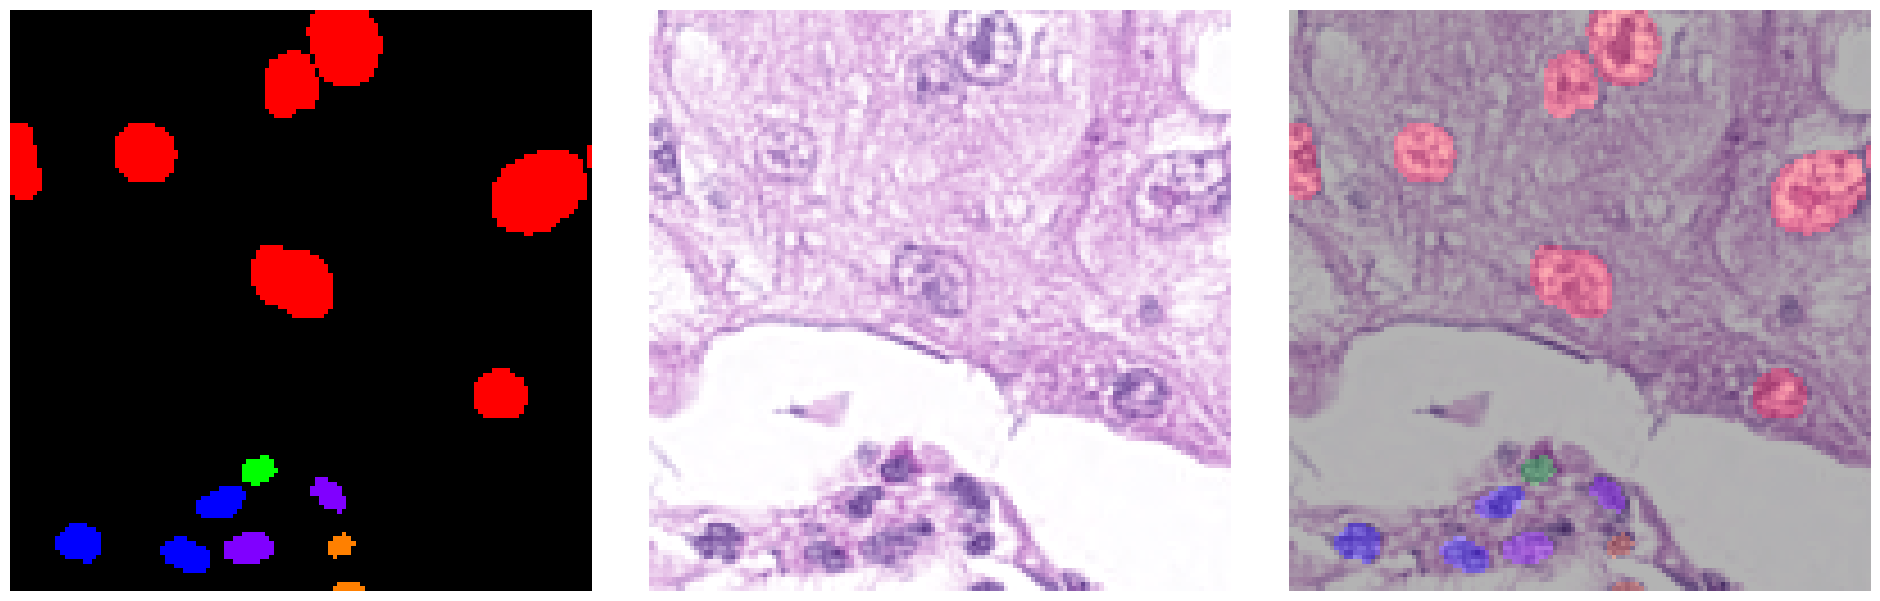

Sample: 23


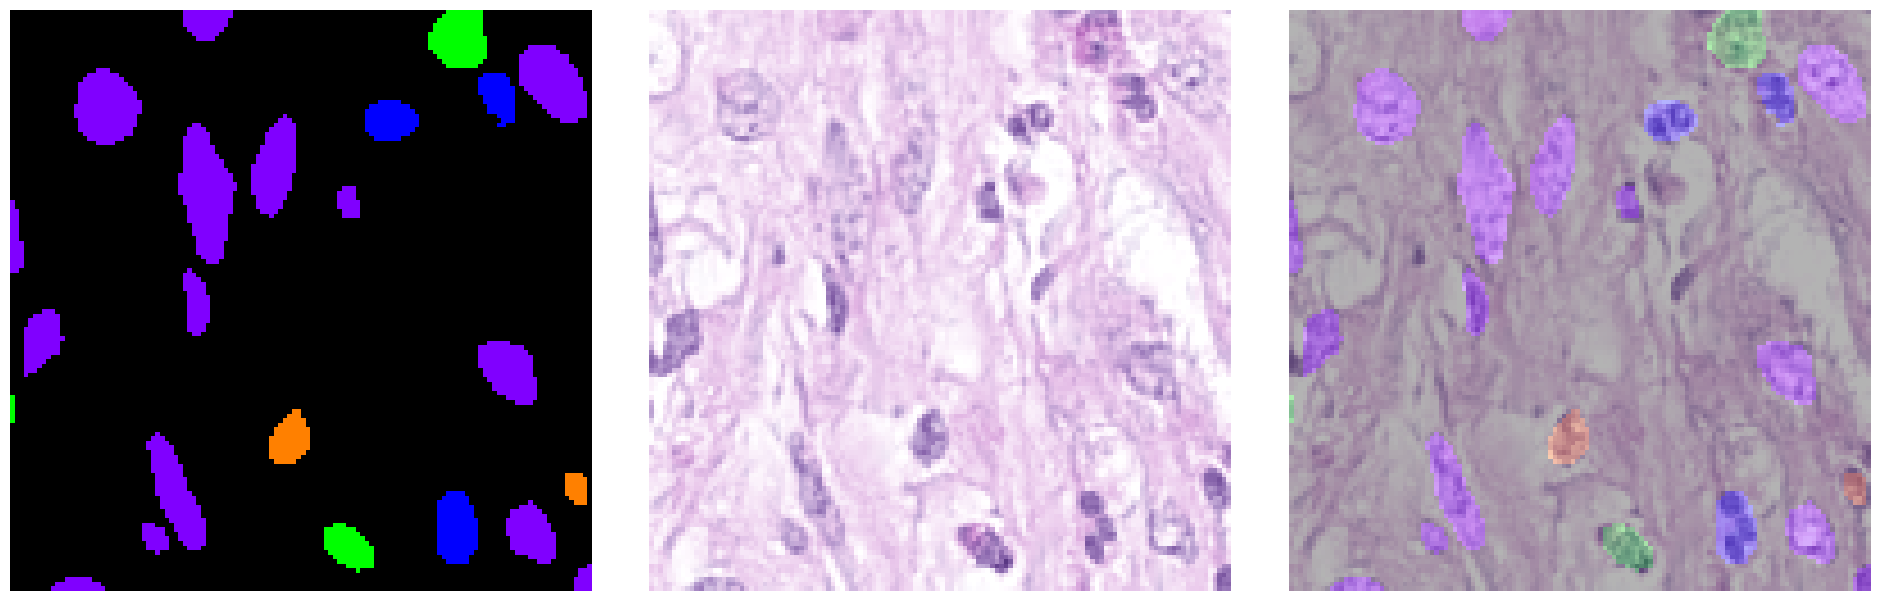

Sample: 24


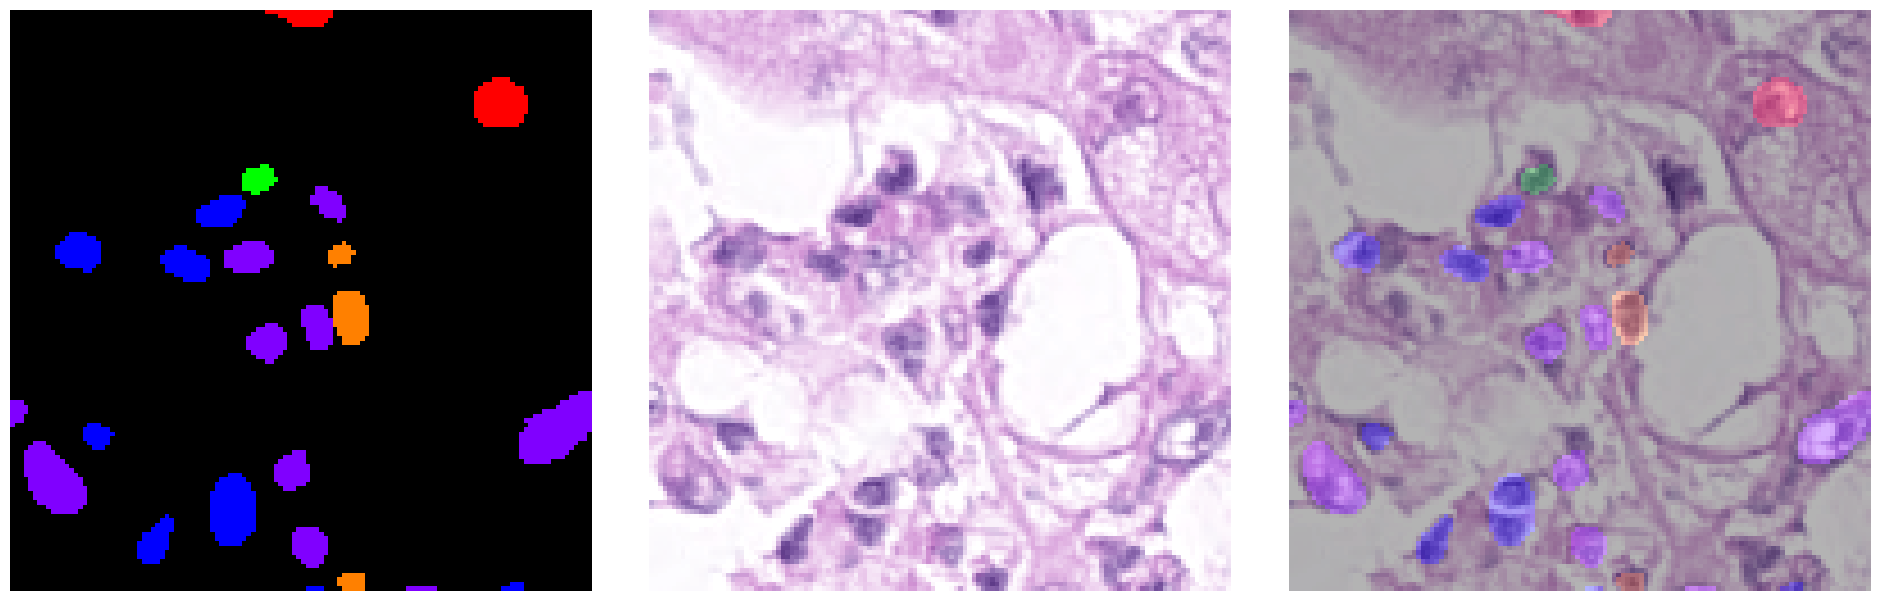

Sample: 25


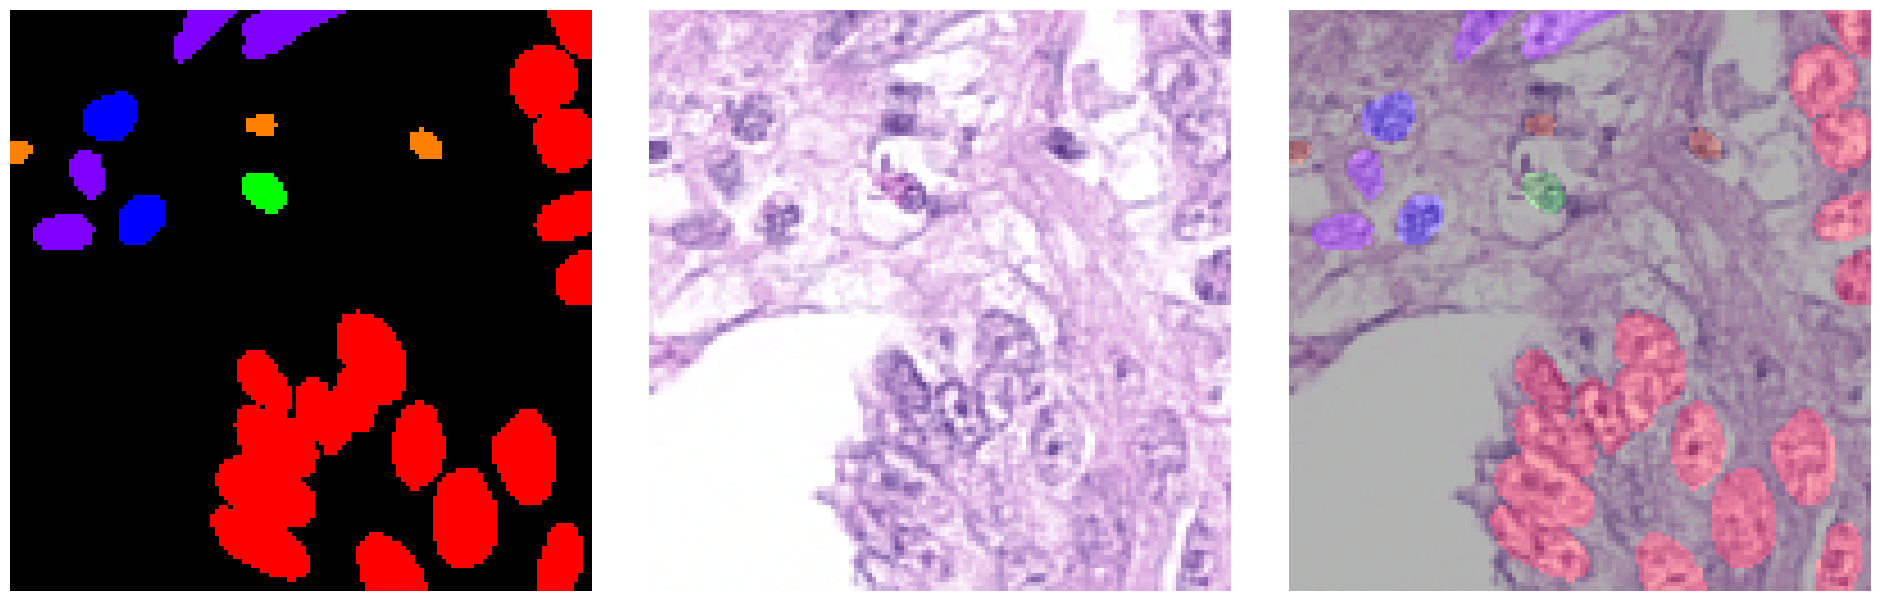

Sample: 26


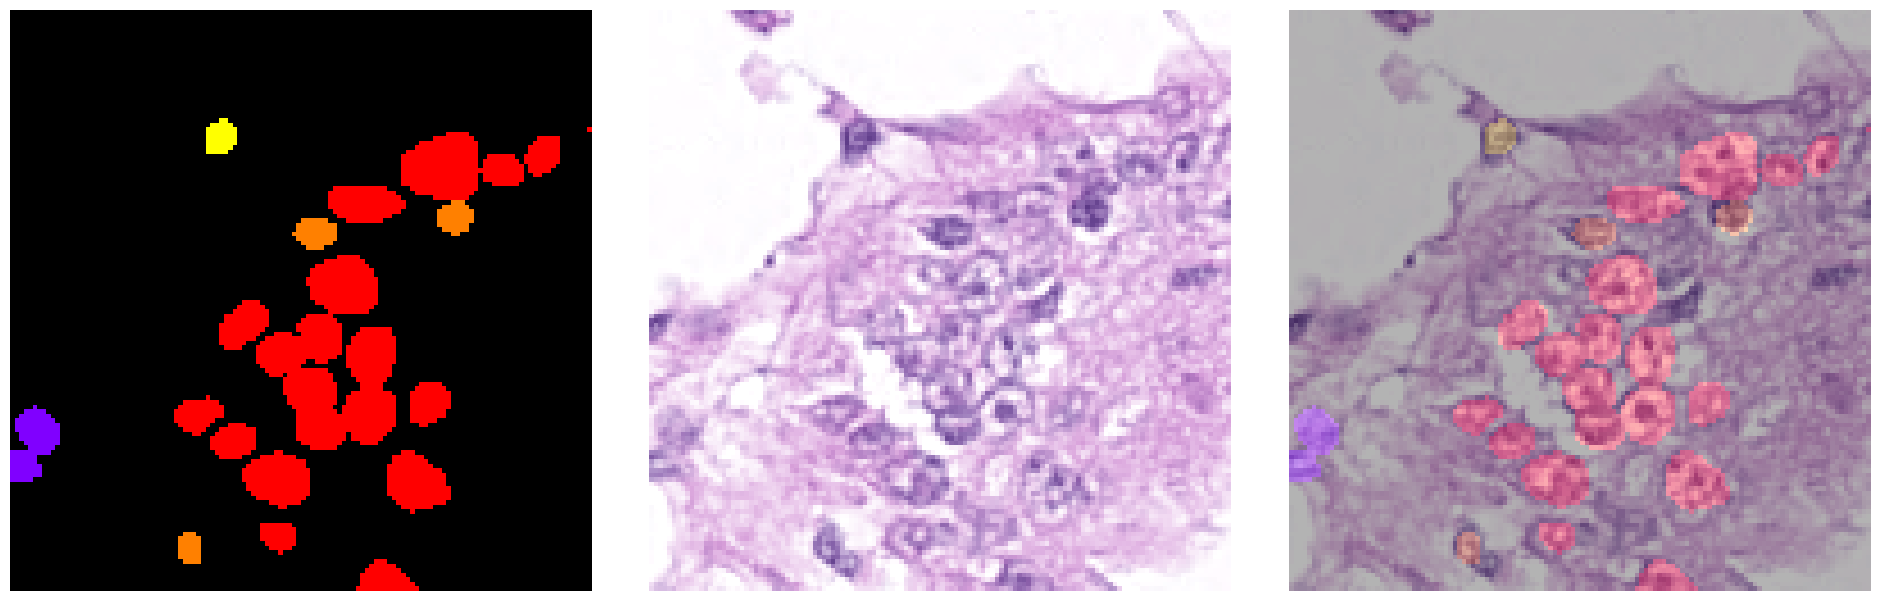

Sample: 27


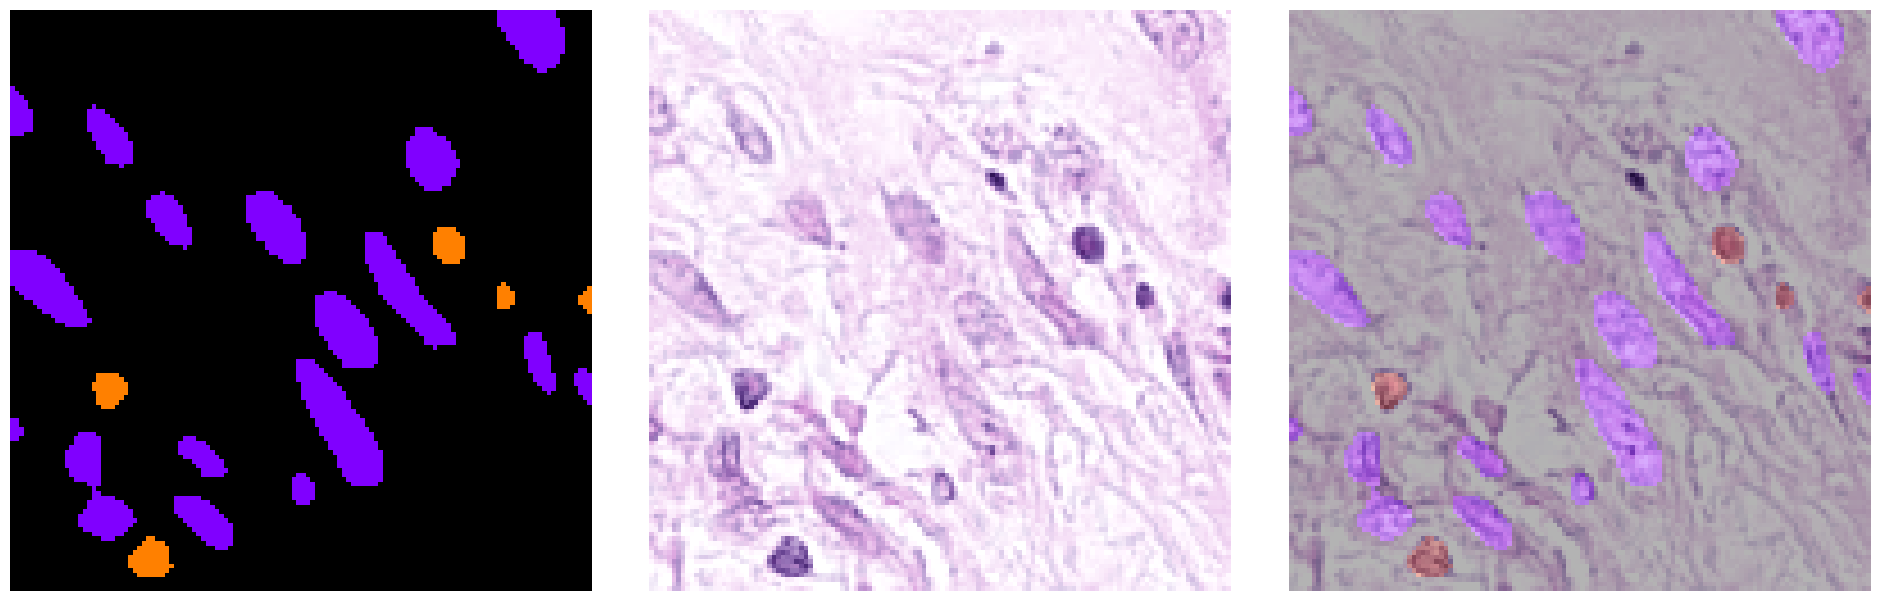

Sample: 28


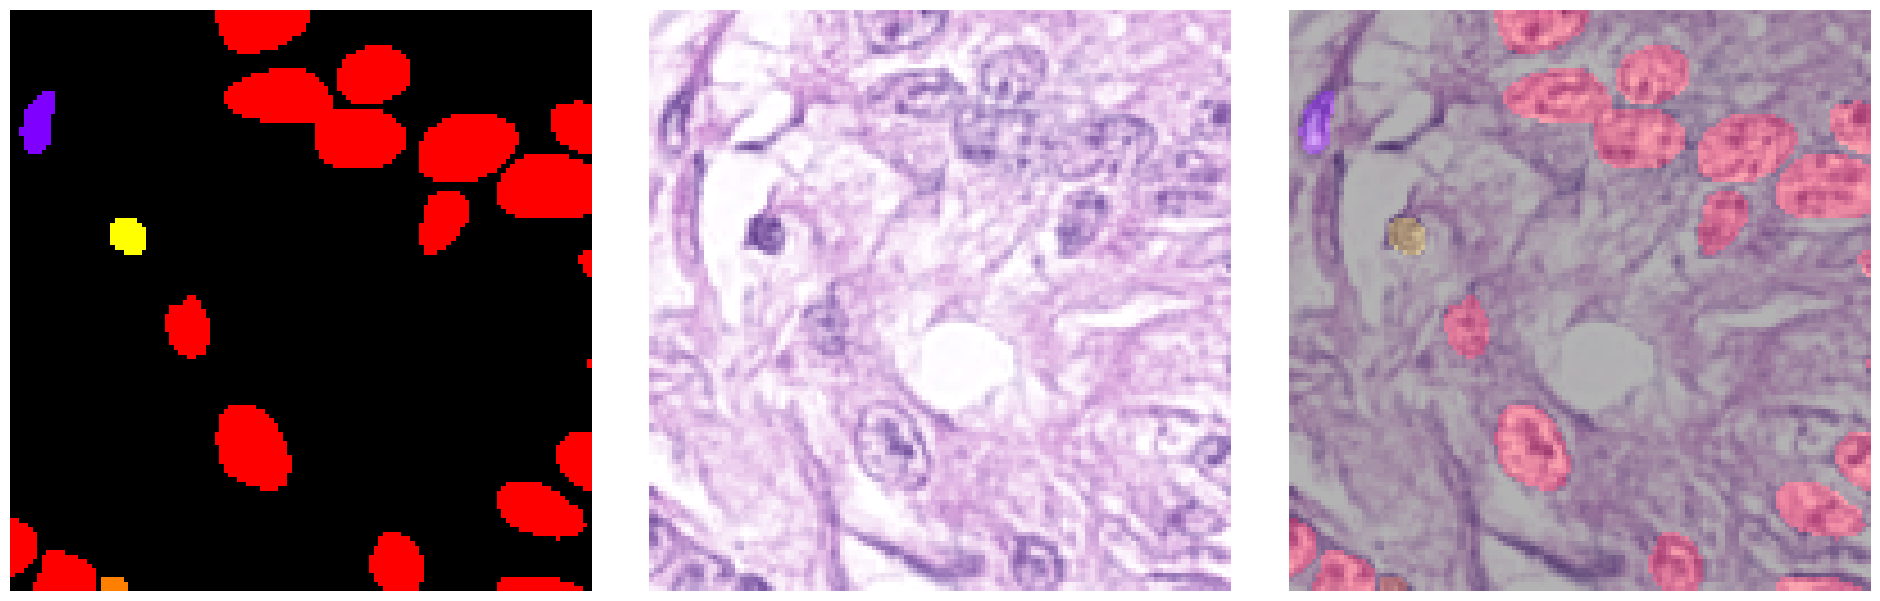

Sample: 29


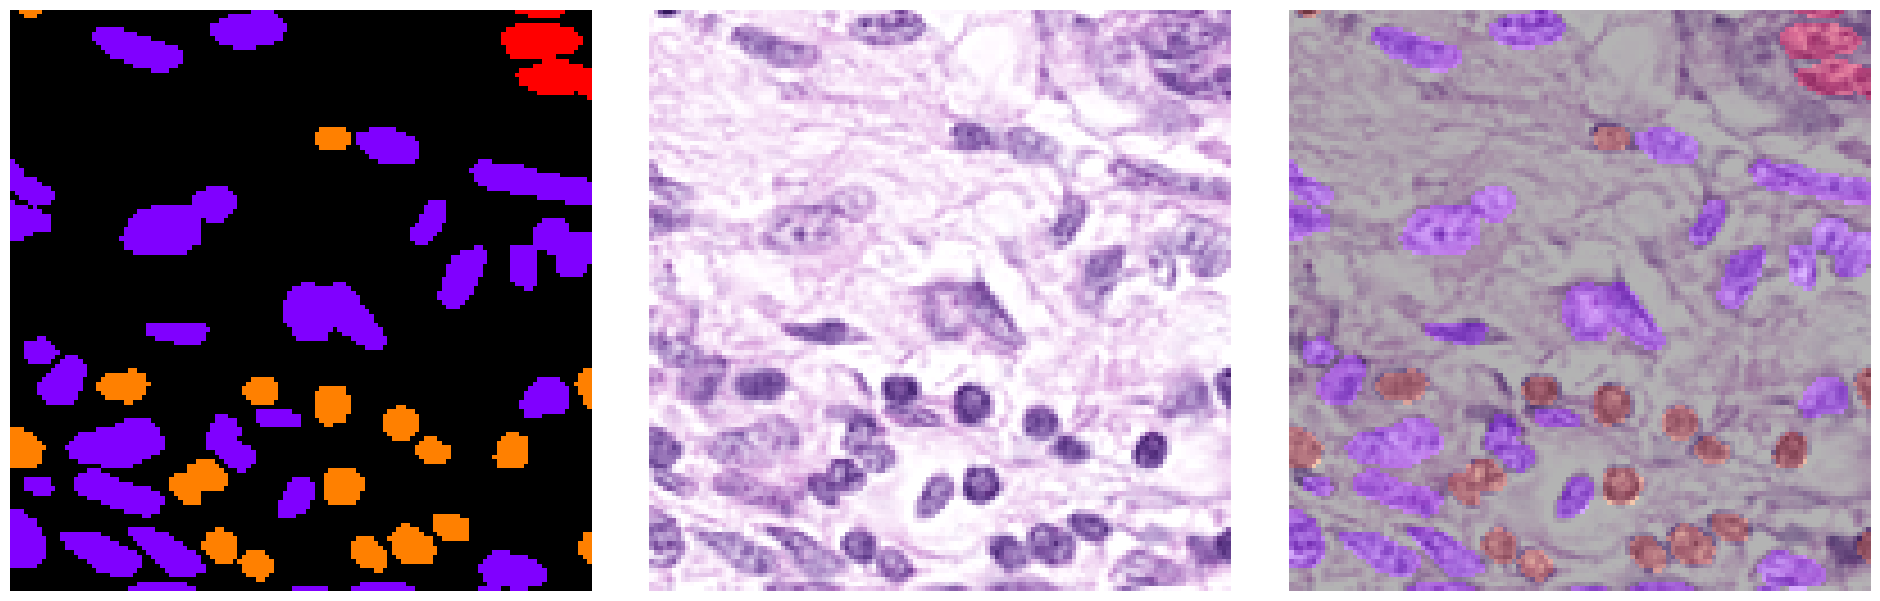

Sample: 30


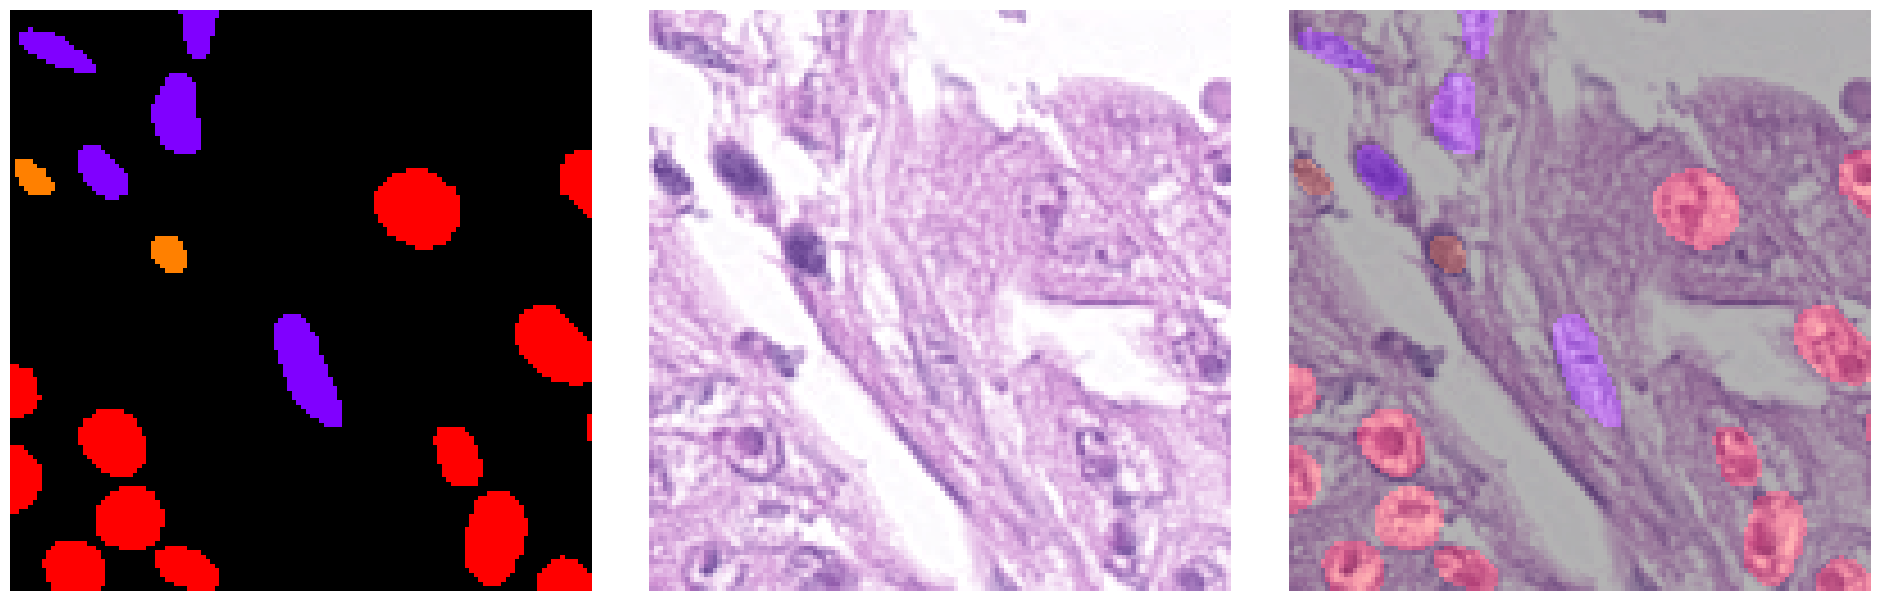

In [258]:
import pandas as pd
results_path = "/scratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"
df = pd.read_csv('/scratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/review/V2/histo_key_v2.csv', header=None)

assert len(df[1].unique()) == len(df)

for idx, row in df.iterrows():
    sample_no = idx + 1
    
    name = row[1]
    clz = row[0]
    
    _, _, smp_zip = load_imgs(None, results_path, name)
    
    print("Sample: " + str(sample_no))
    
    fname = "sample_" + str(sample_no) + ".png"
    filename = os.path.join(results_path, "review", fname)
    
    if clz == "Real":
        display_imgs(smp_zip, 
                     masks=[None, None, smp_zip[0]], 
                     turing=True, 
                     is_sample=False, 
                     is_real=True, 
                     save=True, 
                     filename=filename)
    if clz == "Fake":
        display_imgs(smp_zip, 
                     masks=[None, None, smp_zip[0]], 
                     turing=True, 
                     is_sample=True, 
                     is_real=False, 
                     save=True, 
                     filename=filename)
    

In [118]:
## Visualize Random Samples from a given class
from tqdm import tqdm
masks = {}
results = {}
names = {}
find_class = 6

for idx in tqdm(range(num_samples-1, -1, -1)):
    nam, msks, res = load_imgs(idx, results_path)
    clz = msks[-1]
    if find_class in list(np.unique(np.array(clz))):
        clzid, clzct = np.unique(np.array(clz), return_counts=True)
        
        if dict(zip(clzid, clzct))[find_class] > 100:
            masks[idx] = clz
            results[idx] = res
            names[idx] = nam
        
        if len(masks) >= 500:
            break
            

 28%|██▊       | 647/2304 [00:02<00:05, 287.72it/s]


In [119]:
len(masks)

500

crag_48__128_1344.png
Fake


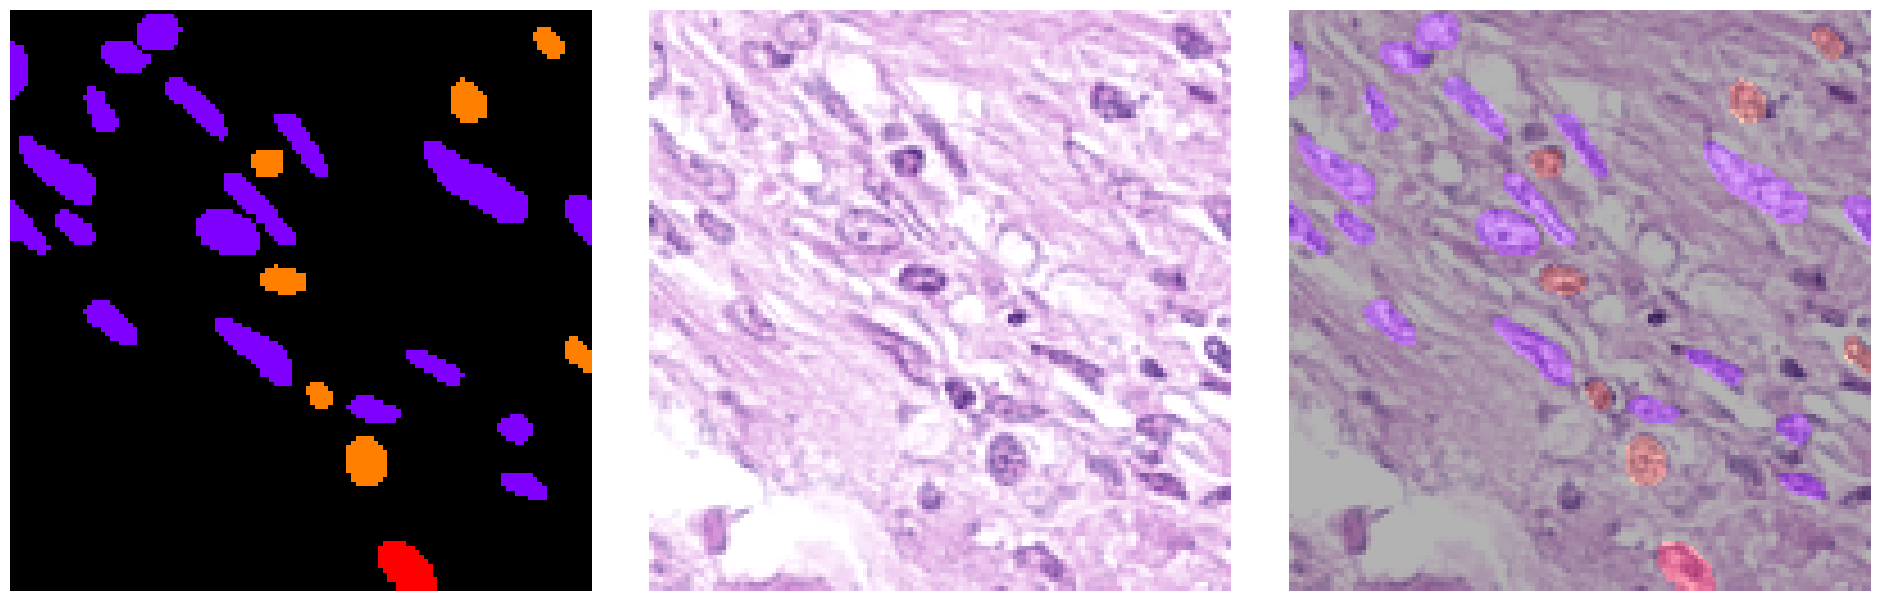

Real


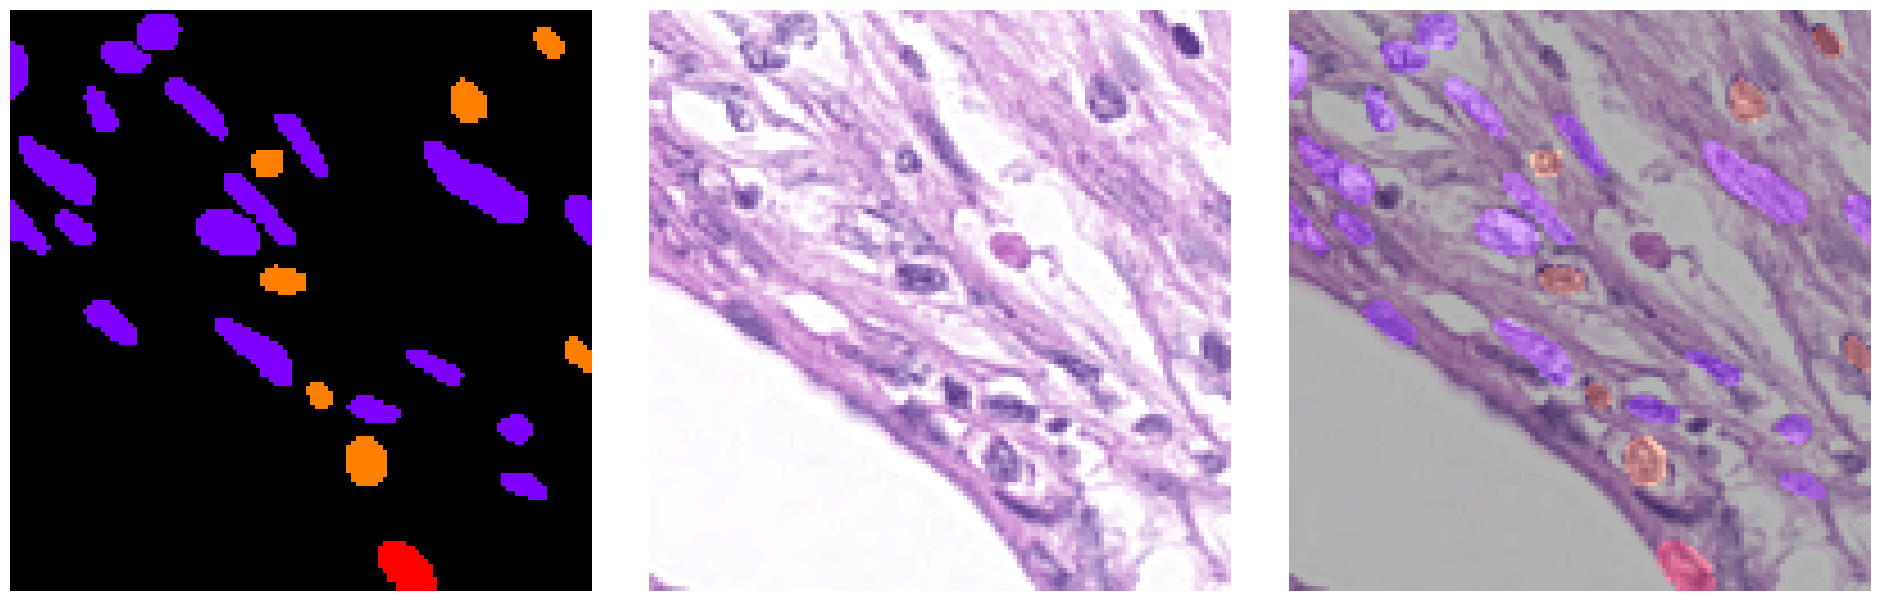

In [120]:
idx = random.randint(1, len(masks)) - 1

msk = masks[list(masks.keys())[idx]]
res = results[list(results.keys())[idx]]
name = names[list(results.keys())[idx]]

# Fake
print(name)
print("Fake")
display_imgs(res, masks=[None, None, res[0]], turing=True, is_sample=True, is_real=False)
# Real
print("Real")
display_imgs(res, masks=[None, None, res[0]], turing=True, is_sample=False, is_real=True)

res[0].save('assets/samples/' + str(idx)+'mask.png')
res[1].save('assets/samples/' + str(idx)+'real.png')
res[2].save('assets/samples/' + str(idx)+'syn.png')

In [121]:
idx

143

In [8]:
idx = 4

results_path = "/oldscratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"
dirs = os.listdir(results_path)

In [9]:
results = {}
maps = {}
for fldr in dirs:
    r_path = os.path.join(results_path, fldr)
    maps[fldr], results[fldr] = load_imgs(idx, r_path)

FileNotFoundError: [Errno 2] No such file or directory: '/oldscratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/samples/images'

In [ ]:
images = []
import matplotlib.pyplot as plt

os.makedirs("assets/" + str(idx), exist_ok=True)

for key, value in results.items():
    image = value[-1]
    title = str(key)
    
    images.append(image)
    
    image.save("assets/" + str(idx) + "/" + key + ".png")
    value[1].save("assets/" + str(idx) + "/real.png")
    color_class_map(maps[key]).save("assets/" + str(idx) + "/mask.png")
    

images = images + [color_class_map(maps[key]), value[1]] 

In [ ]:
display_imgs(images, titles = list(results.keys()) + ["Mask", "Real Image"])

In [ ]:
# Compute FID
from pytorch_gan_metrics import (
    get_inception_score_from_directory,
    get_fid_from_directory,
    get_inception_score_and_fid_from_directory)


(IS, IS_std), FID = get_inception_score_and_fid_from_directory(
    '/scratch/as3ek/github/histofusion/outputs/lizard256_1e4ndnormbri84k_2e5ndnormbridr2_bs40/results/samples/', 
    '/scratch/as3ek/github/histofusion/outputs/lizard256train_stats.npz', use_torch=False)

(IS, IS_std), FID

In [ ]:
## Get masks of images with all nuclei types
# r_path = "/scratch/as3ek/github/histofusion/outputs/lizard_1e4nd140k_1e4ndnormbri208k_2e5ndnormbridr2_bs40/results/val/guidance/g15/"
# masks = {}
# results = {}
# for idx in range(4000):
#     clz, res = load_imgs(idx, r_path)
#     if len(np.unique(np.array(clz))) == 7:
#         masks[idx] = clz
#         results[idx] = res

# image = results[list(masks.keys())[16]][1]
# image

# msk = masks[list(masks.keys())[16]]
# color_class_map(msk)

# mask_arr = np.array(msk)

# mask_arr[mask_arr != 6] = 0
# color_class_map(Image.fromarray(mask_arr))

In [5]:
import numpy as np
from skimage.util import random_noise

def add_gaussian_noise(image):
    # Create an array of Gaussian noise
    noise = np.random.normal(0, 1, image.shape)
    # Add noise to image
    noisy_image = image + noise
    # Clip noisy image to range of 0-1
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image

In [6]:
Image.fromarray((add_gaussian_noise(np.array(image)/255.) * 255).astype(np.uint8))

NameError: name 'image' is not defined

In [ ]:
def get_edges(t):
    edge = th.ByteTensor(t.size()).zero_()
    edge[:, :, :, 1:] = edge[:, :, :, 1:] | (t[:, :, :, 1:] != t[:, :, :, :-1])
    edge[:, :, :, :-1] = edge[:, :, :, :-1] | (t[:, :, :, 1:] != t[:, :, :, :-1])
    edge[:, :, 1:, :] = edge[:, :, 1:, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
    edge[:, :, :-1, :] = edge[:, :, :-1, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
    return edge.float()

In [ ]:
cmask = msk

In [ ]:
import torch
a = torch.tensor(np.array(cmask)).unsqueeze(0).unsqueeze(0)

In [ ]:
Image.fromarray((get_edges(a)[0][0].numpy() * 255.).astype(np.uint8))

In [ ]:
Image.fromarray((get_edges(a)[0][0].numpy() * 255.).astype(np.uint8))

In [ ]:
r_path = "/scratch/as3ek/github/histofusion/outputs/lizard3_1e4nd_2e5nddr02/results/model160k/"

masks = {}
results = {}
find_class = 5

for idx in range(400):
    _, res = load_imgs(idx, r_path)
    clz = _[-1]
    if find_class in list(np.unique(np.array(clz))):
        clzid, clzct = np.unique(np.array(clz), return_counts=True)
        
        if dict(zip(clzid, clzct))[find_class] > 100:
            masks[idx] = clz
            results[idx] = res
        
    if len(results) >= 100:
        break

In [ ]:
masks

In [ ]:
# image = results[list(masks.keys())[16]][1]
# image

# msk = masks[list(masks.keys())[16]]
# color_class_map(msk)

# mask_arr = np.array(msk)

# mask_arr[mask_arr != 6] = 0
# color_class_map(Image.fromarray(mask_arr))

In [ ]:
idx = 1

msk = masks[list(masks.keys())[idx]]
color_class_map(msk)

In [ ]:
_, image, sample = results[list(masks.keys())[idx]]

In [ ]:
image

In [ ]:
sample